In [137]:
pip install pmdarima

     |████████████████████████████████| 656 kB 3.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [339]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Load Data

In [1061]:
east = pd.read_csv('data/east_daily.csv')
midwest = pd.read_csv('data/midwest_daily.csv') 
south = pd.read_csv('data/south_daily.csv') 
west = pd.read_csv('data/west_daily.csv') 

# Check Stationarity

In [284]:
X = east.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.842138
p-value: 0.002504
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [285]:
X = midwest.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.473716
p-value: 0.122001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [286]:
X = south.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.104854
p-value: 0.026196
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [287]:
X = west.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.816341
p-value: 0.055977
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Differencing

In [1048]:
midwest_stationary = midwest['date'].to_frame().join(midwest['daily_deaths'].diff(1).fillna(0))

In [1050]:
west_stationary = west['date'].to_frame().join(west['daily_deaths'].diff(1).fillna(0))

# Check Stationarity After Differencing

In [1051]:
X = midwest_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.612100
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [1053]:
X = west_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.691688
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Split Data Into Train and Test

In [1062]:
east = east.set_index('date')
midwest = midwest.set_index('date')
south = south.set_index('date')
west = west.set_index('date')

In [1066]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [1068]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

TEST SET  TRAINING SET
date                              
2020-02-12       NaN           0.0
2020-02-13       NaN           0.0
2020-02-14       NaN           0.0
2020-02-15       NaN           0.0
2020-02-16       NaN           0.0
...              ...           ...
2023-03-19       0.0           NaN
2023-03-20      37.0           NaN
2023-03-21      33.0           NaN
2023-03-22     184.0           NaN
2023-03-23      89.0           NaN

[1136 rows x 2 columns]

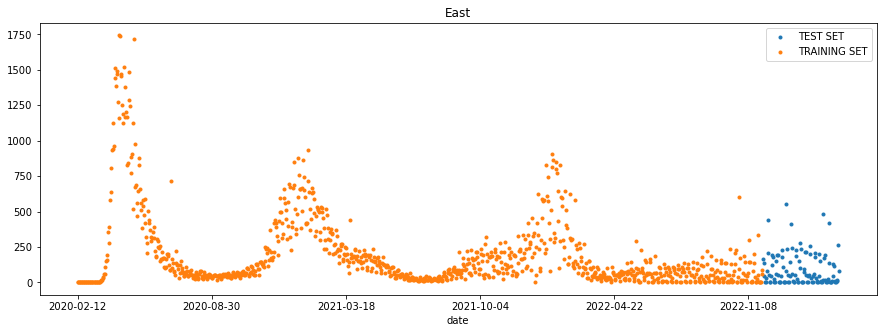

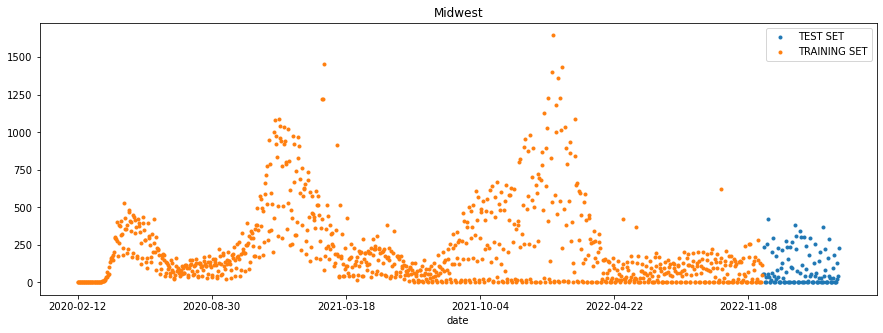

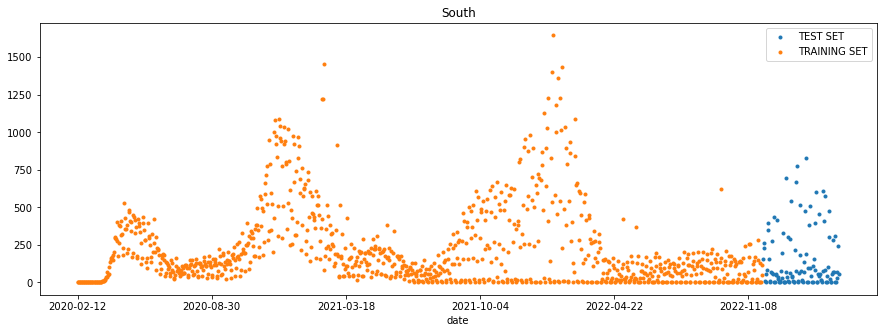

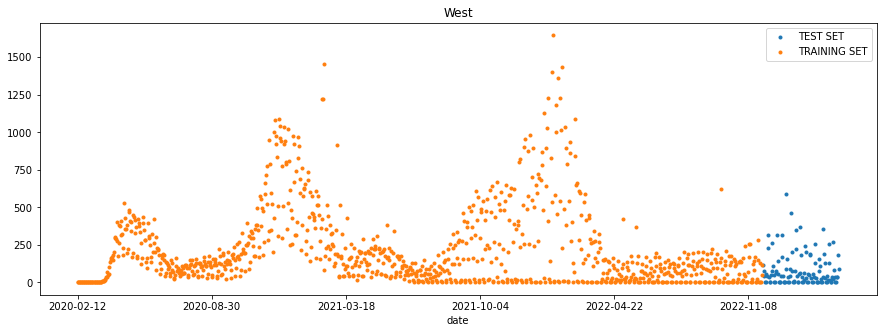

In [1069]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# ACF and PACF

### east

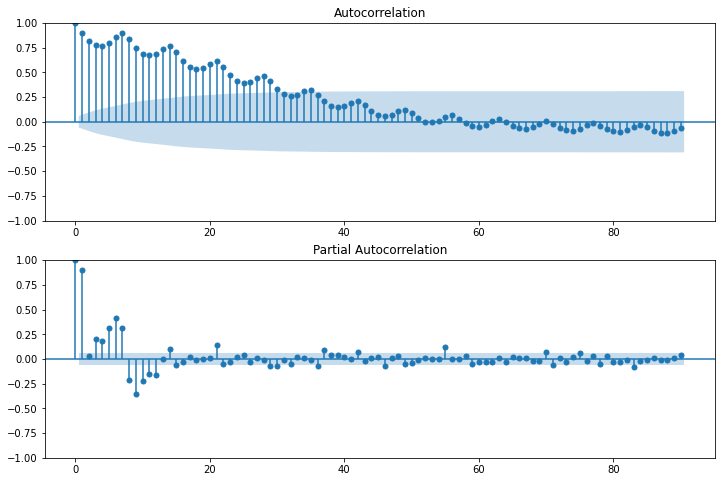

In [1070]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(east,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(east,lags=90,ax=ax2)

### midwest

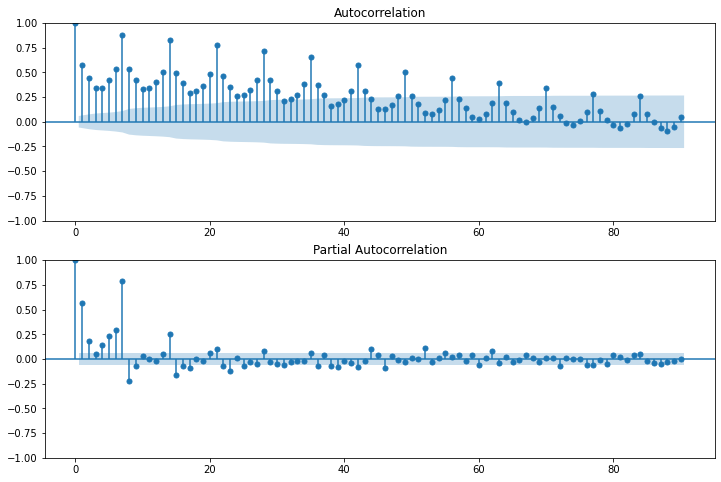

In [1071]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(midwest,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(midwest,lags=90,ax=ax2)

### south

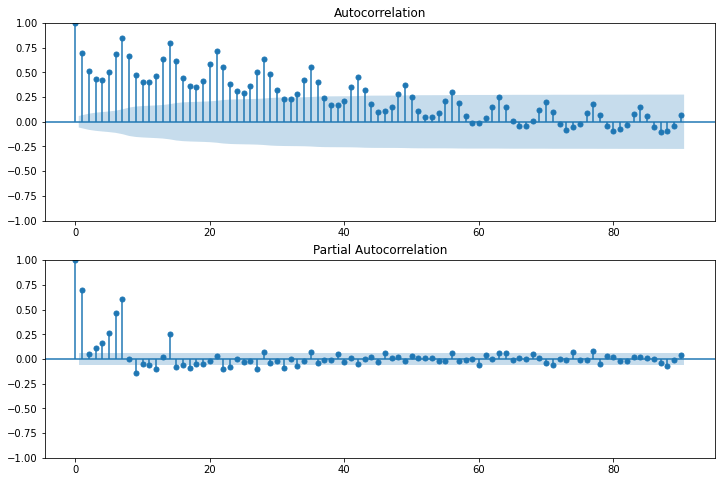

In [1072]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(south,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(south,lags=90,ax=ax2)

### west

MA(5) model
- ACF cut off at lag 5
- PACF tails off

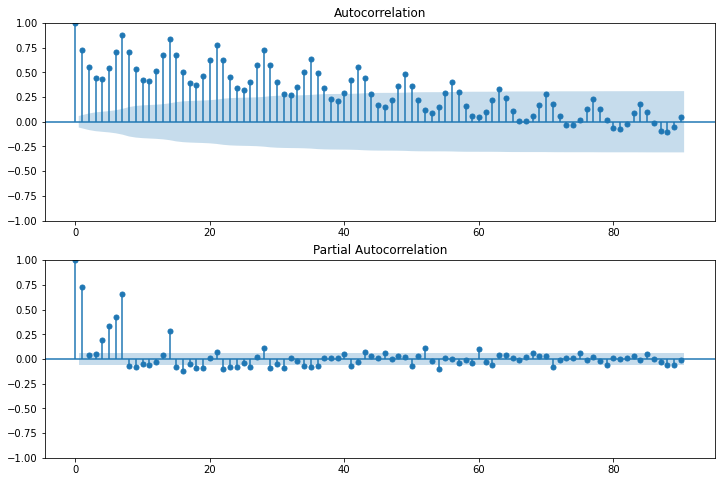

In [1073]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(west,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(west,lags=90,ax=ax2)

# ARIMA Models (grid search p and q)

In [837]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# Grid Search p and q

### east

In [1043]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  11800.445572
41  5  6  11850.802397
47  6  5  11880.336364
40  5  5  11891.908581
33  4  5  11901.431019
26  3  5  11902.678270
39  5  4  11903.549108
27  3  6  11903.933034
34  4  6  11905.450196
46  6  4  11960.565424
44  6  2  11962.957687
45  6  3  11965.641160
37  5  2  12016.985360
32  4  4  12019.444256
24  3  3  12027.195774
25  3  4  12029.635327
30  4  2  12073.746497
31  4  3  12083.189447
43  6  1  12152.529788
20  2  6  12158.521578
42  6  0  12180.746612
13  1  6  12182.622521
19  2  5  12195.805642
12  1  5  12208.567043
18  2  4  12209.989462
36  5  1  12243.971171
17  2  3  12260.905697
11  1  4  12307.445470
29  4  1  12328.592672
35  5  0  12351.407159
22  3  1  12353.494338
38  5  3  12371.939242
10  1  3  12379.417074
16  2  2  12381.431648
9   1  2  12383.470539
23  3  2  12447.937551
28  4  0  12448.209437
21  3  0  12475.857072
15  2  1  12518.578198
7   1  0  12520.989580
8   1  1  12522.338681
14  2  0  12522.655830
5   0  5  12597.621601
6   0  6  12599.607503
4   0  4  12671.147010
3   0  3  12899.533789
2   0  2  13056.429564
1   0  1  13428.904826
0   0  0  14336.038947

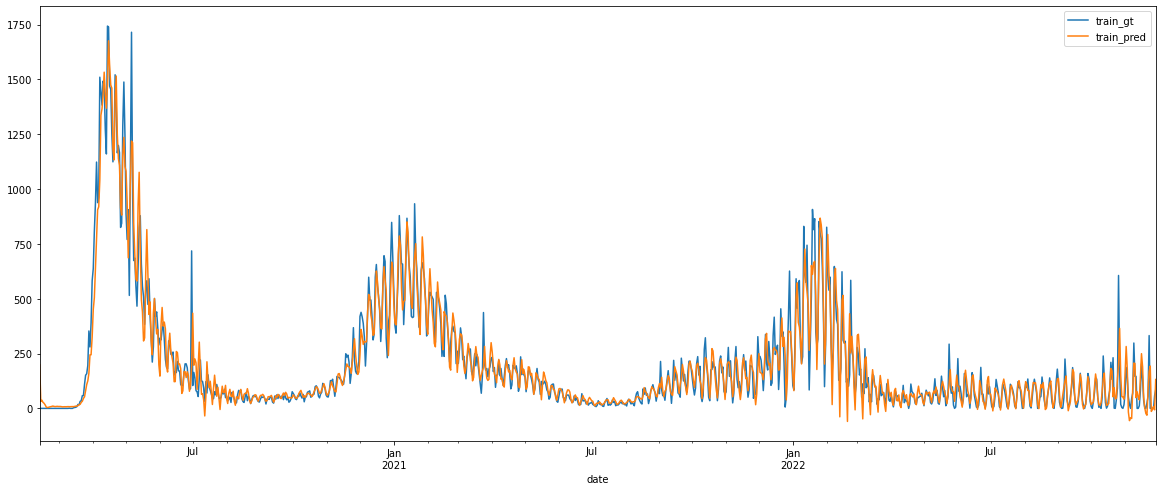

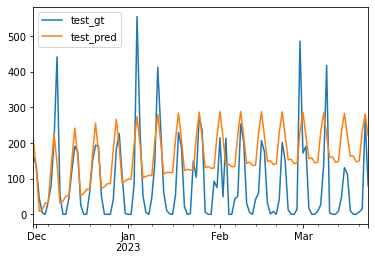

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 45.673374034029656
MASE: 0.7005139763064531

Testing Set Metrics:
MAE: 98.38039679947812
MASE: 1.1108098359653304


In [1044]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,0,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

trying with one difference

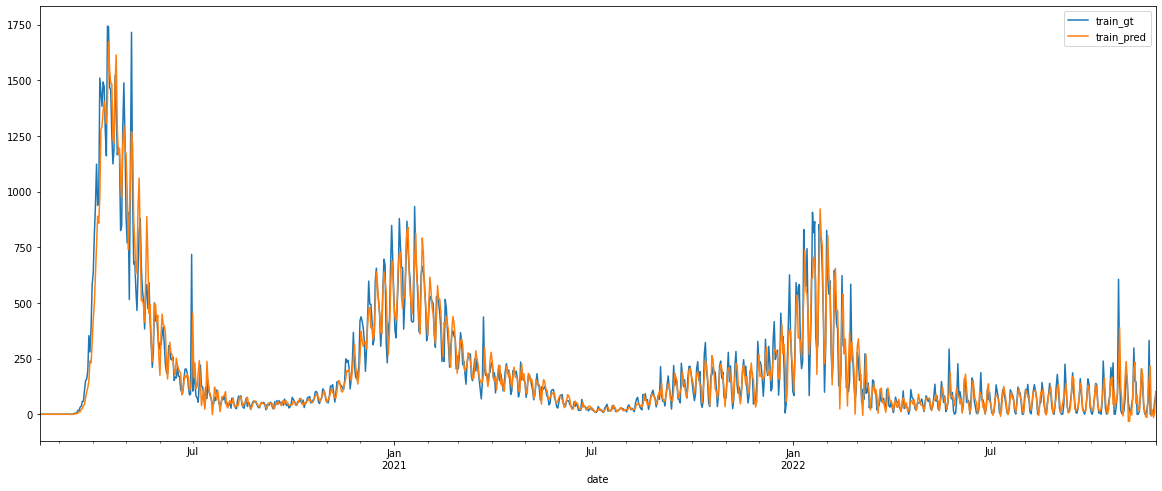

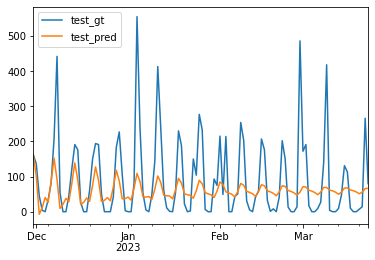

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 45.200839135512716
MASE: 0.6932664867634857

Testing Set Metrics:
MAE: 70.0386259275723
MASE: 0.7908038299176329


In [1045]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred * 2
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1046]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
41  5  6  11794.699914
34  4  6  11838.346423
48  6  6  11839.669618
47  6  5  11843.410448
46  6  4  11845.729041
39  5  4  11868.401756
40  5  5  11875.728325
32  4  4  11879.747778
33  4  5  11881.988769
20  2  6  11886.737025
26  3  5  11887.095317
19  2  5  11887.594189
27  3  6  11888.317229
44  6  2  11898.635882
38  5  3  11928.510325
45  6  3  11931.804347
37  5  2  11942.084444
31  4  3  11943.464347
25  3  4  12006.997907
17  2  3  12014.475052
18  2  4  12015.397262
43  6  1  12069.390322
24  3  3  12071.776765
42  6  0  12084.627046
36  5  1  12138.213616
13  1  6  12155.924965
35  5  0  12167.501869
6   0  6  12175.973476
12  1  5  12189.506336
5   0  5  12199.862971
11  1  4  12204.752614
29  4  1  12230.495135
10  1  3  12258.593168
4   0  4  12296.586301
22  3  1  12316.176021
15  2  1  12341.698707
28  4  0  12343.684066
3   0  3  12368.222642
9   1  2  12370.266360
2   0  2  12372.314546
8   1  1  12419.273209
21  3  0  12449.221165
14  2  0  12484.964094
30  4  2  12492.864007
23  3  2  12509.384871
16  2  2  12510.677625
1   0  1  12543.212848
7   1  0  12547.817839
0   0  0  12549.675638

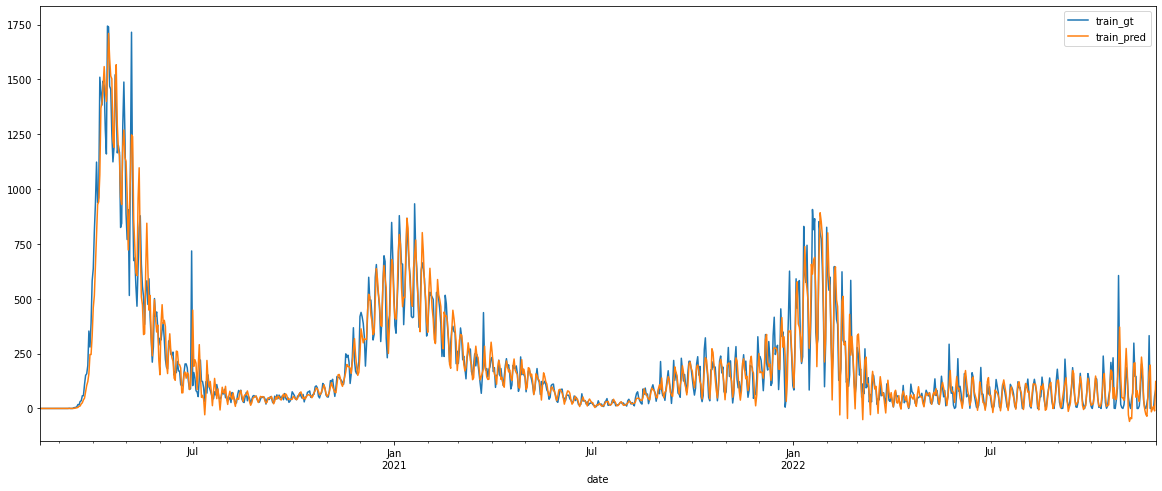

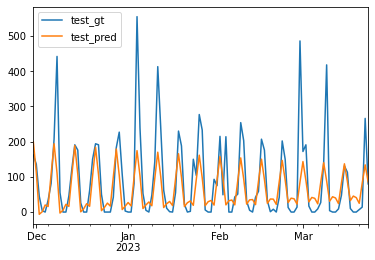

Training Set Metrics:
R-squared: 0.9185244924264576
MAE: 45.03536333134728
MASE: 0.6907285066818725

Testing Set Metrics:
MAE: 54.50067439674024
MASE: 0.6153653284204283


In [1047]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(5,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [1074]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12630.472775
47  6  5  12639.272292
46  6  4  12643.034159
44  6  2  12645.053063
45  6  3  12645.222265
43  6  1  12657.731421
42  6  0  12694.283463
40  5  5  13113.958449
39  5  4  13166.680678
38  5  3  13179.849296
41  5  6  13182.642778
33  4  5  13242.161590
20  2  6  13246.130898
37  5  2  13262.301142
34  4  6  13278.539809
32  4  4  13283.736152
26  3  5  13297.041498
31  4  3  13320.824759
27  3  6  13321.255134
19  2  5  13330.788883
13  1  6  13348.631787
36  5  1  13356.358135
6   0  6  13370.618668
25  3  4  13379.900089
23  3  2  13408.166273
18  2  4  13430.702417
5   0  5  13430.862016
11  1  4  13431.835695
30  4  2  13437.536071
4   0  4  13438.466969
12  1  5  13442.815968
29  4  1  13468.747764
24  3  3  13499.649542
17  2  3  13502.882377
10  1  3  13549.475158
22  3  1  13552.923832
16  2  2  13602.286319
9   1  2  13603.556008
15  2  1  13621.241690
2   0  2  13628.551609
3   0  3  13630.405993
8   1  1  13632.140564
1   0  1  13657.313667
35  5  0  13669.571048
28  4  0  13782.435057
21  3  0  13864.618463
14  2  0  13917.062416
7   1  0  13951.112645
0   0  0  14081.354664

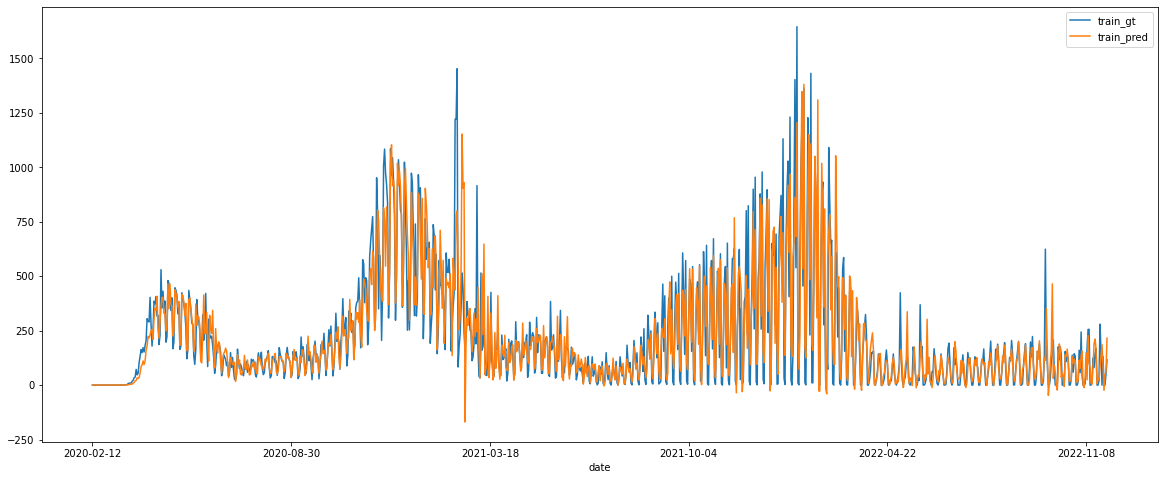

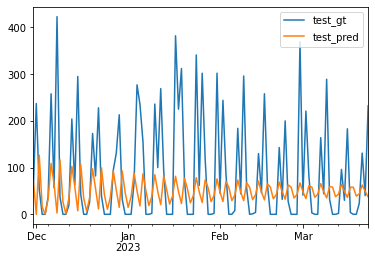

Training Set Metrics:
MAE: 67.6821129215094
MASE: 0.49642560662103336

Testing Set Metrics:
MAE: 79.45209092286146
MASE: 0.6866080050690843


In [1080]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
#test_pred = test_pred * 1.5
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1081]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,2,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
46  6  4  12646.661544
48  6  6  12646.797219
47  6  5  12653.925973
45  6  3  12656.894940
44  6  2  12658.372801
43  6  1  12696.208947
42  6  0  13055.853512
32  4  4  13338.358922
5   0  5  13438.501055
13  1  6  13442.496426
20  2  6  13467.662287
6   0  6  13485.612928
11  1  4  13551.118618
41  5  6  13565.039351
31  4  3  13575.928601
38  5  3  13576.596721
39  5  4  13586.874467
12  1  5  13603.334891
10  1  3  13604.343809
3   0  3  13615.749628
9   1  2  13619.566953
4   0  4  13632.846321
33  4  5  13633.396907
34  4  6  13637.267154
40  5  5  13639.225474
2   0  2  13658.079548
36  5  1  13668.368633
24  3  3  13704.821504
18  2  4  13713.439683
37  5  2  13715.961376
30  4  2  13716.846126
26  3  5  13729.980024
19  2  5  13742.165700
17  2  3  13762.858722
29  4  1  13780.562274
27  3  6  13852.209562
22  3  1  13862.173653
16  2  2  13888.127734
25  3  4  13892.829432
15  2  1  13914.158409
23  3  2  13918.130237
8   1  1  13947.926166
1   0  1  14077.414076
28  4  0  14292.695648
35  5  0  14292.737958
21  3  0  14360.428901
14  2  0  14443.609270
7   1  0  14601.099932
0   0  0  15080.660635

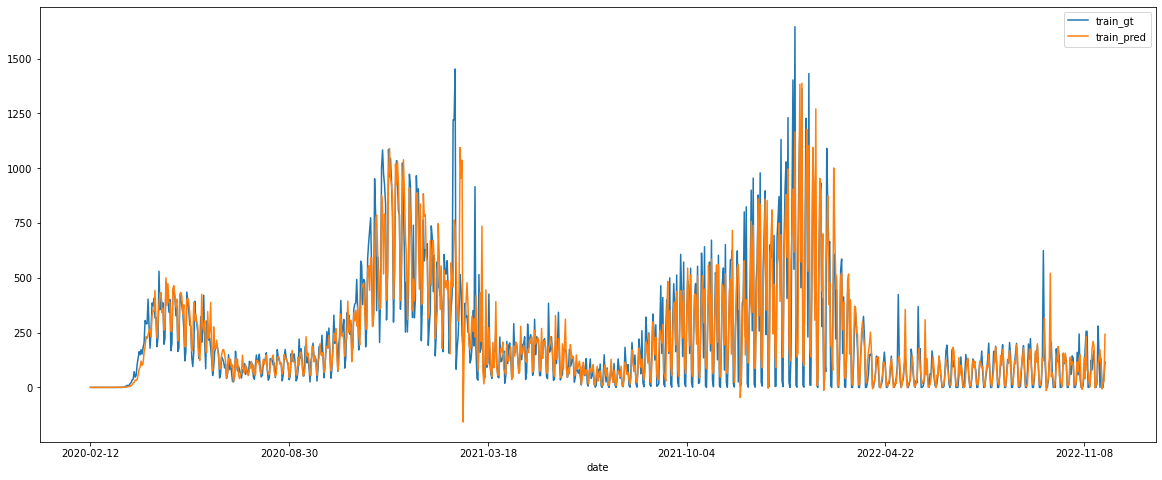

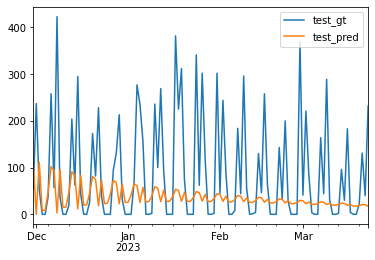

Training Set Metrics:
MAE: 67.6707299086543
MASE: 0.4963421160381031

Testing Set Metrics:
MAE: 79.26121162757828
MASE: 0.6849584669559763


In [1084]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,2,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [1021]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
47  6  5  13766.923601
48  6  6  13767.072344
46  6  4  13808.822345
41  5  6  13820.829905
40  5  5  13851.555699
44  6  2  13908.078246
39  5  4  13924.070243
25  3  4  13969.786373
33  4  5  13976.741487
27  3  6  13977.713714
34  4  6  13984.004583
26  3  5  13984.293609
43  6  1  14013.893309
45  6  3  14017.108393
37  5  2  14021.959453
32  4  4  14032.798224
23  3  2  14190.517540
36  5  1  14222.360196
20  2  6  14236.949101
42  6  0  14239.817935
13  1  6  14250.662187
19  2  5  14259.602145
12  1  5  14276.484290
18  2  4  14279.486439
11  1  4  14292.867390
29  4  1  14325.247551
22  3  1  14385.667124
24  3  3  14390.016651
9   1  2  14419.919164
16  2  2  14421.837117
17  2  3  14436.718079
38  5  3  14441.104111
30  4  2  14503.164523
35  5  0  14506.284838
28  4  0  14569.416988
5   0  5  14570.704969
4   0  4  14572.899466
21  3  0  14591.411705
10  1  3  14603.158305
7   1  0  14603.718409
8   1  1  14604.473626
14  2  0  14604.942471
15  2  1  14605.368536
31  4  3  14623.393763
3   0  3  14628.978176
2   0  2  14692.230932
6   0  6  14705.220133
1   0  1  14820.569982
0   0  0  15288.411602

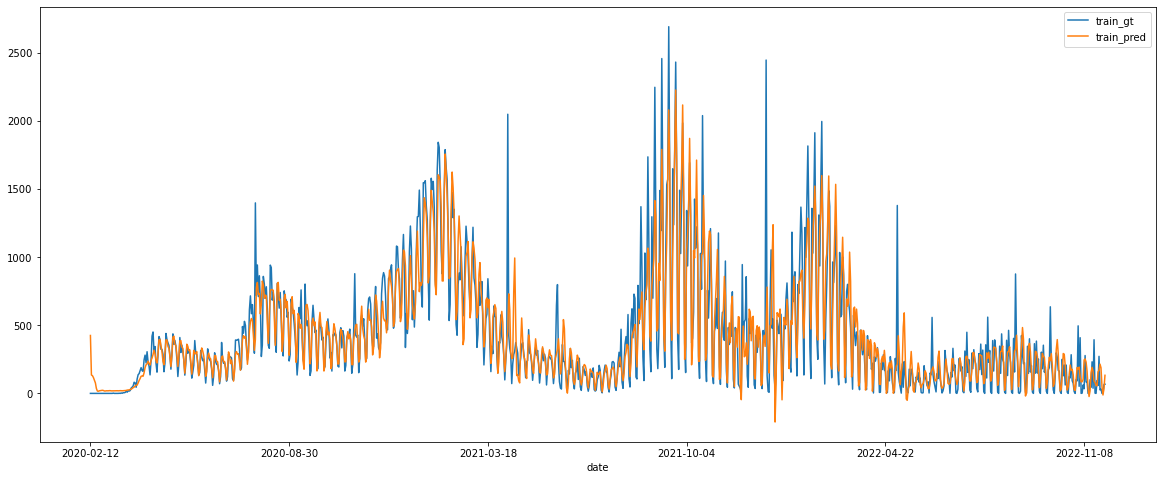

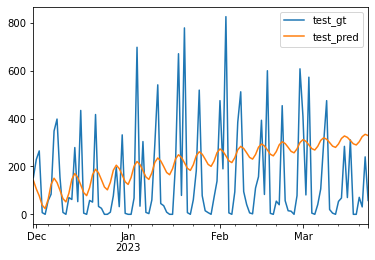

Training Set Metrics:
MAE: 118.53238085779554
MASE: 0.5790865501481396

Testing Set Metrics:
MAE: 178.18747826399175
MASE: 0.9218140843213418


In [1086]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,0,5))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

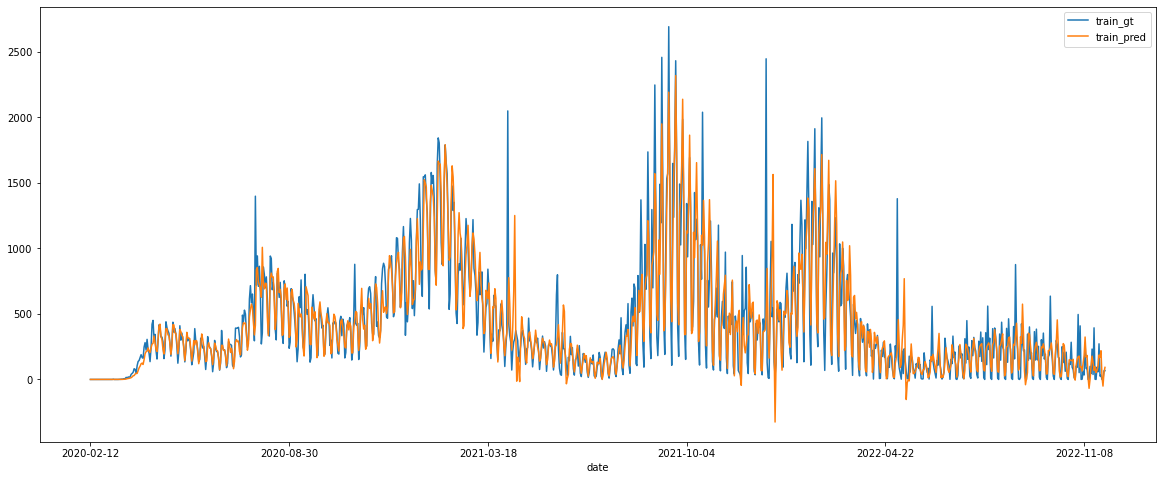

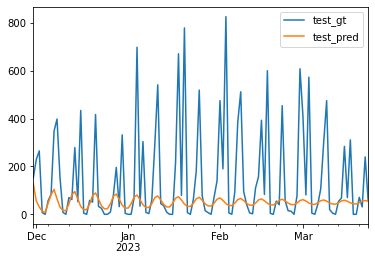

Training Set Metrics:
MAE: 114.56522833605325
MASE: 0.5597051401814963

Testing Set Metrics:
MAE: 124.69837903300031
MASE: 0.645099886953671


In [1087]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,5))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1028]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  13691.965504
47  6  5  13700.398448
46  6  4  13705.530740
44  6  2  13738.629887
45  6  3  13739.944455
42  6  0  13753.338087
41  5  6  13753.528866
43  6  1  13755.313100
40  5  5  13757.925840
39  5  4  13774.456337
34  4  6  13811.094377
38  5  3  13816.742515
37  5  2  13821.393281
33  4  5  13840.432353
32  4  4  13857.428730
31  4  3  13884.579160
19  2  5  13909.458248
26  3  5  13933.389826
18  2  4  13939.935574
27  3  6  13948.246848
25  3  4  13960.226137
20  2  6  13965.186842
17  2  3  13966.196811
30  4  2  13968.934938
36  5  1  13996.352759
24  3  3  14010.812609
23  3  2  14112.513503
16  2  2  14180.623386
29  4  1  14199.881128
13  1  6  14222.528666
6   0  6  14229.907222
35  5  0  14233.415474
12  1  5  14247.341498
5   0  5  14264.354403
11  1  4  14267.349284
4   0  4  14279.802891
22  3  1  14310.048198
10  1  3  14312.628530
15  2  1  14370.859352
2   0  2  14405.416321
3   0  3  14407.206308
9   1  2  14407.341939
8   1  1  14436.116171
28  4  0  14524.196271
1   0  1  14533.908190
21  3  0  14614.906610
14  2  0  14667.215902
7   1  0  14721.767368
0   0  0  14751.020836

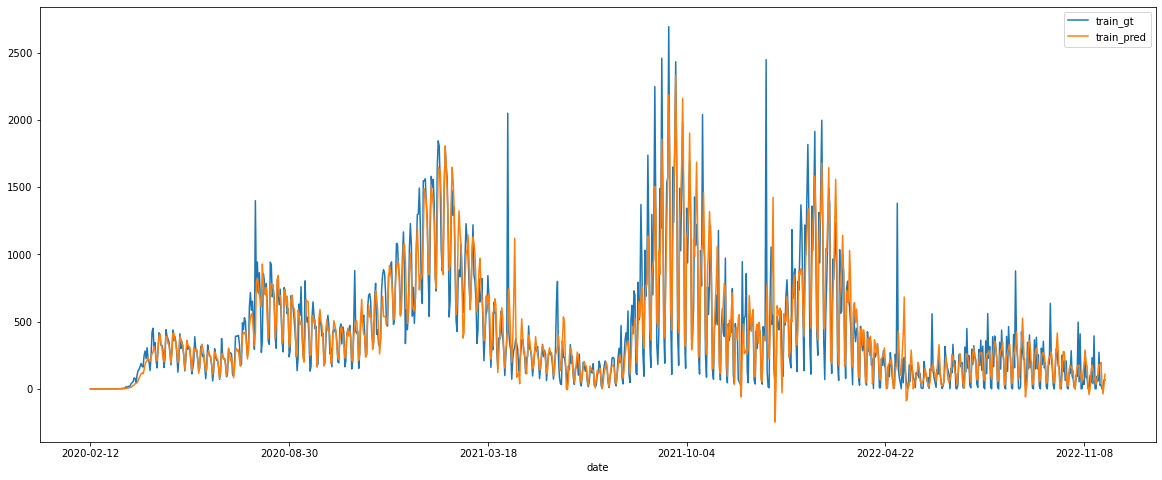

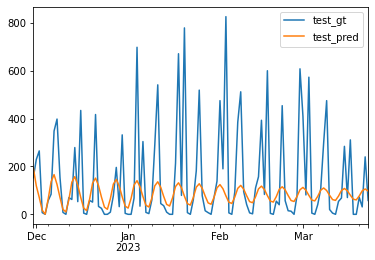

Training Set Metrics:
MAE: 115.66437949123166
MASE: 0.5650750116540623

Testing Set Metrics:
MAE: 118.7965734293231
MASE: 0.6145681819124439


In [1091]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)


### west

In [1092]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12129.174671
47  6  5  12146.148748
46  6  4  12158.133332
44  6  2  12175.214099
45  6  3  12175.614082
43  6  1  12178.410534
42  6  0  12180.200129
41  5  6  12268.903209
40  5  5  12279.653852
37  5  2  12315.004659
19  2  5  12334.520470
39  5  4  12339.003889
31  4  3  12353.526762
38  5  3  12358.264670
24  3  3  12365.278023
20  2  6  12367.801510
18  2  4  12376.061542
25  3  4  12377.913813
26  3  5  12380.568361
17  2  3  12381.007805
33  4  5  12390.134550
34  4  6  12392.587880
27  3  6  12412.351925
32  4  4  12422.359033
36  5  1  12491.270603
23  3  2  12552.357705
29  4  1  12618.108693
30  4  2  12677.267586
13  1  6  12692.920819
12  1  5  12694.111478
6   0  6  12714.861752
5   0  5  12730.505844
11  1  4  12734.023586
35  5  0  12738.062363
22  3  1  12747.506894
4   0  4  12752.349529
15  2  1  12866.476179
10  1  3  12890.333860
3   0  3  12893.815578
9   1  2  12901.185628
2   0  2  12902.125817
16  2  2  12904.463799
8   1  1  12920.924692
28  4  0  12951.476802
1   0  1  13036.853113
21  3  0  13101.758210
14  2  0  13174.354703
7   1  0  13196.214718
0   0  0  13224.403623

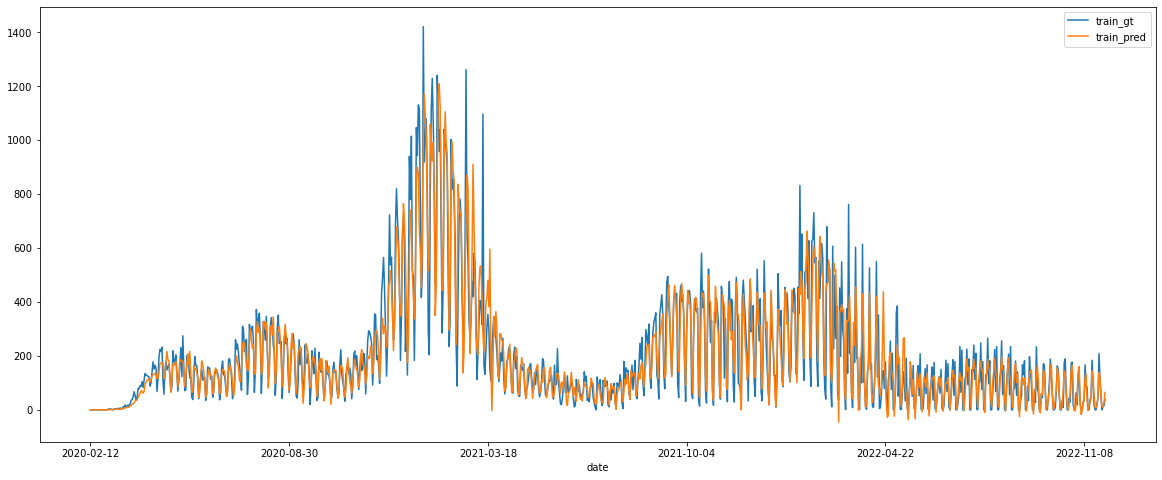

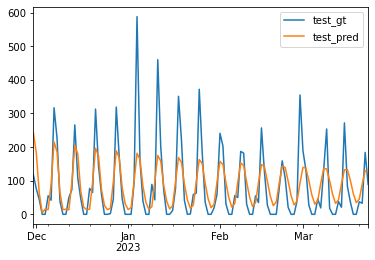

Training Set Metrics:
MAE: 54.93198630179385
MASE: 0.5467174664586933

Testing Set Metrics:
MAE: 51.75648266296938
MASE: 0.5785421447141695


In [1096]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

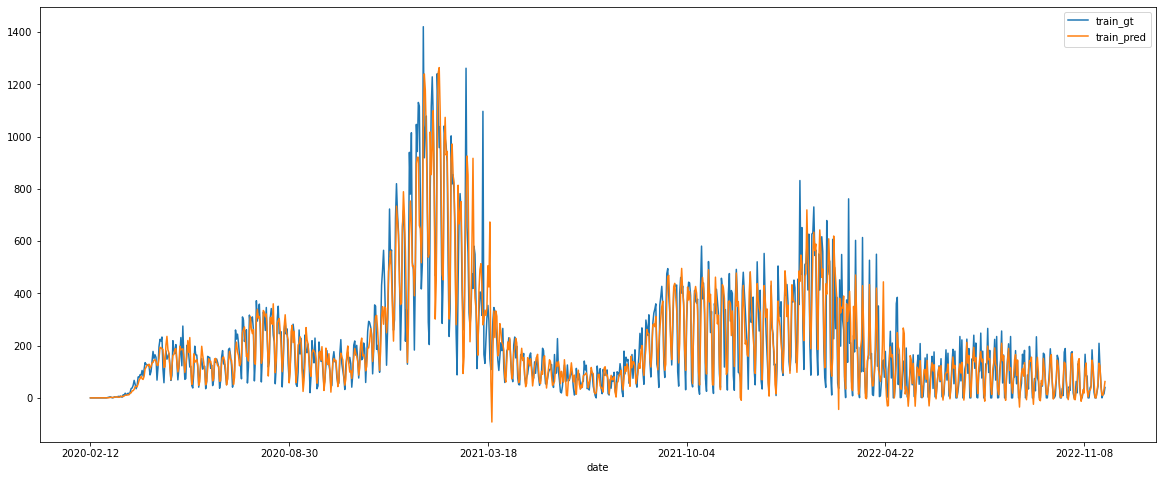

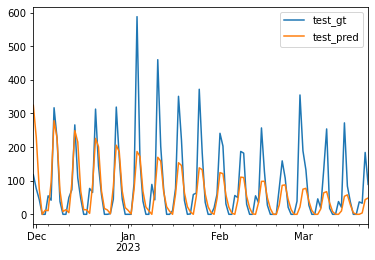

Training Set Metrics:
MAE: 55.0513071477983
MASE: 0.5479050221073252

Testing Set Metrics:
MAE: 48.44481794518326
MASE: 0.5415238330008614


In [1099]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,2,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1100]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,2,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12165.744088
47  6  5  12168.987193
45  6  3  12176.284378
46  6  4  12178.032008
43  6  1  12181.539249
44  6  2  12258.238182
39  5  4  12442.588684
37  5  2  12478.915416
38  5  3  12622.182350
41  5  6  12638.233483
42  6  0  12664.863405
34  4  6  12677.115849
40  5  5  12702.656985
6   0  6  12731.248126
36  5  1  12737.869141
5   0  5  12754.434654
13  1  6  12758.865220
19  2  5  12762.884296
32  4  4  12774.637411
18  2  4  12828.969521
12  1  5  12852.206721
20  2  6  12857.597711
26  3  5  12868.344986
11  1  4  12870.142492
10  1  3  12871.108949
3   0  3  12872.301412
4   0  4  12895.102168
27  3  6  12936.779899
29  4  1  12950.355415
2   0  2  13016.402815
30  4  2  13017.376142
33  4  5  13028.576017
31  4  3  13030.263387
24  3  3  13096.669502
22  3  1  13099.861035
17  2  3  13118.276716
25  3  4  13125.485573
15  2  1  13171.918491
23  3  2  13175.288368
16  2  2  13177.460466
8   1  1  13193.524831
1   0  1  13221.398402
9   1  2  13224.323141
35  5  0  13475.879521
28  4  0  13547.254118
21  3  0  13617.716192
14  2  0  13666.941916
7   1  0  13757.633859
0   0  0  14080.266960

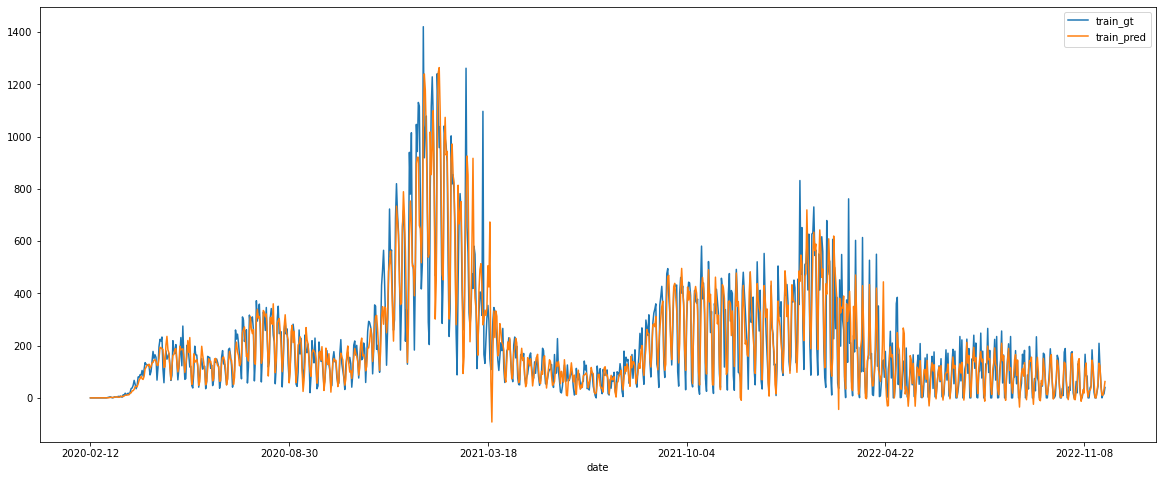

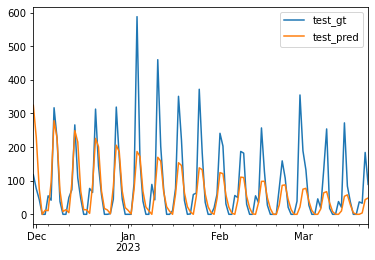

Training Set Metrics:
R-squared: 0.8202199100684161
MAE: 55.0513071477983
MASE: 0.5479050221073252

Testing Set Metrics:
R-squared: 0.42663118450068027
MAE: 48.44481794518326
MASE: 0.5415238330008614


In [1104]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,2,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
west_test[west_test<0]=0
test_pred = test_pred * 2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

# Time Series Decomposition

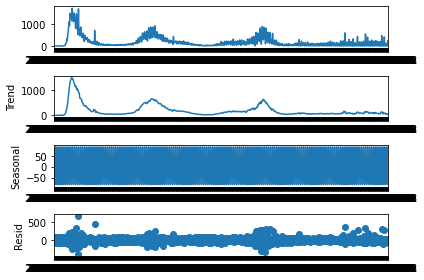

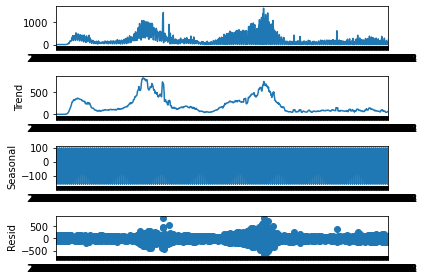

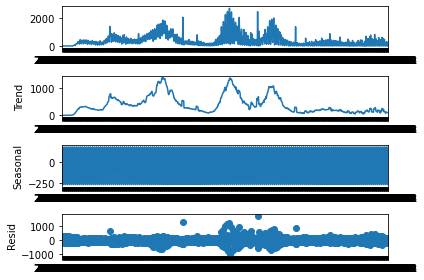

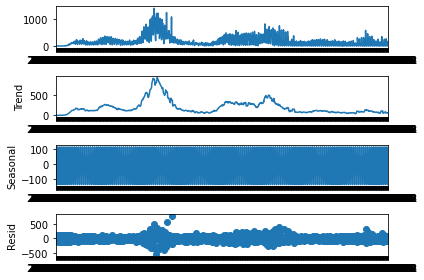

In [1106]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(east, period=7).plot()
plt.show()

seasonal_decompose(midwest, period=7).plot()
plt.show()

seasonal_decompose(south, period=7).plot()
plt.show()

seasonal_decompose(west, period=7).plot()
plt.show()

# Auto ARIMA / SARIMA

### east

In [493]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37700D+00    |proj g|=  5.68911D-01

At iterate    5    f=  6.11792D+00    |proj g|=  1.05995D-02


 This problem is unconstrained.



At iterate   10    f=  6.10029D+00    |proj g|=  7.08456D-03

At iterate   15    f=  6.09947D+00    |proj g|=  4.24803D-03

At iterate   20    f=  6.09923D+00    |proj g|=  1.36731D-03

At iterate   25    f=  6.09868D+00    |proj g|=  4.71995D-03

At iterate   30    f=  6.09829D+00    |proj g|=  4.67682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   4.947D-05   6.098D+00
  F =   6.0982934322631435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  6.10738D+00    |proj g|=  1.28182D-02

At iterate   10    f=  6.09655D+00    |proj g|=  7.63254D-02

At iterate   15    f=  6.08142D+00    |proj g|=  1.20575D-02

At iterate   20    f=  6.08102D+00    |proj g|=  1.26267D-02

At iterate   25    f=  6.07999D+00    |proj g|=  7.53625D-04

At iterate   30    f=  6.07976D+00    |proj g|=  4.67736D-03

At iterate   35    f=  6.07814D+00    |proj g|=  5.21546D-03

At iterate   40    f=  6.07812D+00    |proj g|=  5.63377D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     52      1     0     0   9.285D-06   6.078D+00
  F =   6.07812335404

 This problem is unconstrained.



At iterate    5    f=  6.11657D+00    |proj g|=  1.04143D-02

At iterate   10    f=  6.08042D+00    |proj g|=  1.33656D-01

At iterate   15    f=  6.06712D+00    |proj g|=  3.11404D-03

At iterate   20    f=  6.06521D+00    |proj g|=  1.98821D-02

At iterate   25    f=  6.06259D+00    |proj g|=  1.96493D-03

At iterate   30    f=  6.06248D+00    |proj g|=  6.30393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   1.911D-05   6.062D+00
  F =   6.0624562321494420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.11852D+00    |proj g|=  3.01038D-02

At iterate   10    f=  6.10174D+00    |proj g|=  1.78488D-02

At iterate   15    f=  6.09916D+00    |proj g|=  2.68312D-02

At iterate   20    f=  6.06138D+00    |proj g|=  9.54803D-02

At iterate   25    f=  6.05257D+00    |proj g|=  1.01034D-02

At iterate   30    f=  6.04373D+00    |proj g|=  1.02814D-01

At iterate   35    f=  6.04018D+00    |proj g|=  2.16391D-01

At iterate   40    f=  6.03348D+00    |proj g|=  9.13129D-01

At iterate   45    f=  6.02721D+00    |proj g|=  1.71982D+00

At iterate   50    f=  6.02628D+00    |proj g|=  1.17677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.03835D+00    |proj g|=  3.13706D-03

At iterate   10    f=  6.03671D+00    |proj g|=  2.19605D-02

At iterate   15    f=  6.03630D+00    |proj g|=  6.41067D-04

At iterate   20    f=  6.03589D+00    |proj g|=  1.54653D-03

At iterate   25    f=  6.03588D+00    |proj g|=  5.49341D-04

At iterate   30    f=  6.03582D+00    |proj g|=  1.26680D-03

At iterate   35    f=  6.03582D+00    |proj g|=  2.08712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     38      1     0     0   2.087D-05   6.036D+00
  F =   6.0358165672879887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.03745D+00    |proj g|=  4.80376D-03

At iterate   10    f=  6.03289D+00    |proj g|=  6.06335D-02

At iterate   15    f=  6.02616D+00    |proj g|=  1.91102D-03

At iterate   20    f=  6.02610D+00    |proj g|=  5.05886D-03

At iterate   25    f=  6.02530D+00    |proj g|=  7.20245D-03

At iterate   30    f=  6.02522D+00    |proj g|=  1.04170D-04

At iterate   35    f=  6.02522D+00    |proj g|=  5.06222D-04

At iterate   40    f=  6.02515D+00    |proj g|=  3.41017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     50      1     0     0   4.951D-05   6.025D+00
  F =   6.02513497075

 This problem is unconstrained.



At iterate    5    f=  6.03863D+00    |proj g|=  1.36969D-02

At iterate   10    f=  6.02550D+00    |proj g|=  7.76492D-02

At iterate   15    f=  6.02252D+00    |proj g|=  1.31883D-02

At iterate   20    f=  6.02221D+00    |proj g|=  9.62122D-04

At iterate   25    f=  6.02203D+00    |proj g|=  1.09273D-02

At iterate   30    f=  6.02097D+00    |proj g|=  2.00719D-03

At iterate   35    f=  6.02096D+00    |proj g|=  1.96969D-03

At iterate   40    f=  6.02085D+00    |proj g|=  2.26348D-03

At iterate   45    f=  6.02084D+00    |proj g|=  1.43848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     59   

 This problem is unconstrained.



At iterate    5    f=  6.03771D+00    |proj g|=  8.80864D-03

At iterate   10    f=  6.03273D+00    |proj g|=  1.97328D-02

At iterate   15    f=  6.02326D+00    |proj g|=  7.86015D-02

At iterate   20    f=  6.01076D+00    |proj g|=  1.17742D-02

At iterate   25    f=  5.99894D+00    |proj g|=  3.64081D-01

At iterate   30    f=  5.99441D+00    |proj g|=  3.12418D-02

At iterate   35    f=  5.98958D+00    |proj g|=  1.62916D-01

At iterate   40    f=  5.98587D+00    |proj g|=  2.38804D-01

At iterate   45    f=  5.98043D+00    |proj g|=  2.22838D+00

At iterate   50    f=  5.97990D+00    |proj g|=  1.89830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.12138D+00    |proj g|=  8.20950D-03

At iterate   15    f=  6.11114D+00    |proj g|=  1.34863D-02

At iterate   20    f=  6.10835D+00    |proj g|=  6.58172D-03

At iterate   25    f=  6.10821D+00    |proj g|=  1.65795D-04

At iterate   30    f=  6.10820D+00    |proj g|=  5.95846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   2.532D-05   6.108D+00
  F =   6.1081996922991832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.14127D+00    |proj g|=  1.02650D-01

At iterate   10    f=  6.11339D+00    |proj g|=  7.21567D-03

At iterate   15    f=  6.11303D+00    |proj g|=  1.16844D-03

At iterate   20    f=  6.10378D+00    |proj g|=  1.86128D-02

At iterate   25    f=  6.10231D+00    |proj g|=  2.37067D-04

At iterate   30    f=  6.10230D+00    |proj g|=  7.97480D-04

At iterate   35    f=  6.10225D+00    |proj g|=  3.07045D-04

At iterate   40    f=  6.10225D+00    |proj g|=  1.83871D-04

At iterate   45    f=  6.10225D+00    |proj g|=  3.99433D-04

At iterate   50    f=  6.10225D+00    |proj g|=  2.55810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.15760D+00    |proj g|=  7.64426D-02

At iterate   10    f=  6.11794D+00    |proj g|=  1.77291D-02

At iterate   15    f=  6.11603D+00    |proj g|=  9.44097D-03

At iterate   20    f=  6.10121D+00    |proj g|=  1.75462D-02

At iterate   25    f=  6.09880D+00    |proj g|=  1.64788D-02

At iterate   30    f=  6.09868D+00    |proj g|=  1.62780D-04

At iterate   35    f=  6.09866D+00    |proj g|=  2.46157D-03

At iterate   40    f=  6.09860D+00    |proj g|=  2.54186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     49      1     0     0   3.680D-05   6.099D+00
  F =   6.09859805144

 This problem is unconstrained.



At iterate    5    f=  6.14780D+00    |proj g|=  8.47443D-02

At iterate   10    f=  6.12271D+00    |proj g|=  3.89734D-02

At iterate   15    f=  6.10900D+00    |proj g|=  8.10691D-03

At iterate   20    f=  6.10720D+00    |proj g|=  1.29493D-02

At iterate   25    f=  6.10678D+00    |proj g|=  2.67931D-03

At iterate   30    f=  6.10238D+00    |proj g|=  7.32242D-02

At iterate   35    f=  6.09628D+00    |proj g|=  3.28906D-02

At iterate   40    f=  6.08282D+00    |proj g|=  6.55399D-02

At iterate   45    f=  6.07733D+00    |proj g|=  1.91468D-02

At iterate   50    f=  6.07133D+00    |proj g|=  9.18829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20389D+00    |proj g|=  1.53421D-01

At iterate   10    f=  6.10157D+00    |proj g|=  1.84238D-02

At iterate   15    f=  6.05955D+00    |proj g|=  9.49673D-02

At iterate   20    f=  6.04810D+00    |proj g|=  1.46444D-02

At iterate   25    f=  6.03771D+00    |proj g|=  1.59776D-02

At iterate   30    f=  6.03508D+00    |proj g|=  3.07871D-03

At iterate   35    f=  6.03491D+00    |proj g|=  5.75325D-03

At iterate   40    f=  6.03473D+00    |proj g|=  2.94805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   6.858D-05   6.035D+00
  F =   6.03473162852

 This problem is unconstrained.



At iterate    5    f=  6.20080D+00    |proj g|=  1.74176D-01

At iterate   10    f=  6.09341D+00    |proj g|=  1.41422D-02

At iterate   15    f=  6.05913D+00    |proj g|=  1.26126D-01

At iterate   20    f=  6.04418D+00    |proj g|=  1.65399D-02

At iterate   25    f=  6.04288D+00    |proj g|=  3.06383D-03

At iterate   30    f=  6.04277D+00    |proj g|=  8.29744D-04

At iterate   35    f=  6.04092D+00    |proj g|=  3.04711D-02

At iterate   40    f=  6.02910D+00    |proj g|=  4.82950D-02

At iterate   45    f=  6.02647D+00    |proj g|=  6.82119D-03

At iterate   50    f=  6.02546D+00    |proj g|=  2.15518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.21975D+00    |proj g|=  1.14231D-01

At iterate   10    f=  6.10395D+00    |proj g|=  1.75212D-02

At iterate   15    f=  6.06941D+00    |proj g|=  9.69728D-02

At iterate   20    f=  6.04512D+00    |proj g|=  1.28704D-02

At iterate   25    f=  6.03933D+00    |proj g|=  5.39920D-03

At iterate   30    f=  6.03366D+00    |proj g|=  7.46245D-02

At iterate   35    f=  6.02593D+00    |proj g|=  5.91808D-02

At iterate   40    f=  6.02396D+00    |proj g|=  1.84599D-03

At iterate   45    f=  6.02377D+00    |proj g|=  2.46975D-03

At iterate   50    f=  6.02235D+00    |proj g|=  3.43094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20648D+00    |proj g|=  1.63123D-01

At iterate   10    f=  6.11138D+00    |proj g|=  2.39033D-02

At iterate   15    f=  6.06242D+00    |proj g|=  5.74002D-02

At iterate   20    f=  6.04520D+00    |proj g|=  9.51415D-03

At iterate   25    f=  6.04089D+00    |proj g|=  5.29633D-03

At iterate   30    f=  6.03639D+00    |proj g|=  1.31500D-02

At iterate   35    f=  6.03480D+00    |proj g|=  1.49647D-03

At iterate   40    f=  6.03471D+00    |proj g|=  4.02442D-04

At iterate   45    f=  6.03471D+00    |proj g|=  1.09594D-04

At iterate   50    f=  6.03463D+00    |proj g|=  1.98091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [494]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
7   1  2  2  2  12238.910978
6   1  2  2  1  12320.597627
14  2  2  2  1  12325.679620
5   1  2  1  2  12329.375880
3   1  1  2  2  12331.715189
13  2  2  1  2  12332.049899
12  2  2  1  1  12348.991449
4   1  2  1  1  12349.209064
15  2  2  2  2  12352.775339
2   1  1  2  1  12403.660539
11  2  1  2  2  12425.788513
1   1  1  1  2  12435.684136
0   1  1  1  1  12474.911776
10  2  1  2  1  12479.534417
9   2  1  1  2  12486.993927
8   2  1  1  1  12497.160171

In [934]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,0,q), seasonal_order=(P,0,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04244D+00    |proj g|=  3.24097D-01

At iterate    5    f=  5.90524D+00    |proj g|=  5.87898D-03


 This problem is unconstrained.



At iterate   10    f=  5.89718D+00    |proj g|=  5.03602D-03

At iterate   15    f=  5.88202D+00    |proj g|=  7.95648D-02

At iterate   20    f=  5.82916D+00    |proj g|=  1.70714D-02

At iterate   25    f=  5.82852D+00    |proj g|=  7.29329D-04

At iterate   30    f=  5.82665D+00    |proj g|=  3.91625D-02

At iterate   35    f=  5.82122D+00    |proj g|=  1.59154D-03

At iterate   40    f=  5.82114D+00    |proj g|=  4.13829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     54      1     0     0   4.138D-06   5.821D+00
  F =   5.8211407960899386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.90400D+00    |proj g|=  4.68233D-03

At iterate   10    f=  5.89672D+00    |proj g|=  7.30429D-03

At iterate   15    f=  5.88141D+00    |proj g|=  6.89913D-02

At iterate   20    f=  5.82908D+00    |proj g|=  1.54046D-02

At iterate   25    f=  5.82869D+00    |proj g|=  3.39286D-04

At iterate   30    f=  5.82588D+00    |proj g|=  2.24337D-02
  ys=-2.207E-04  -gs= 1.131E-03 BFGS update SKIPPED

At iterate   35    f=  5.82137D+00    |proj g|=  3.07285D-03

At iterate   40    f=  5.82100D+00    |proj g|=  2.26721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     1

 This problem is unconstrained.



At iterate   10    f=  5.88688D+00    |proj g|=  2.69026D-02

At iterate   15    f=  5.87304D+00    |proj g|=  3.51526D-02

At iterate   20    f=  5.83092D+00    |proj g|=  2.14922D-02

At iterate   25    f=  5.82990D+00    |proj g|=  1.51048D-04

At iterate   30    f=  5.82982D+00    |proj g|=  7.87903D-03

At iterate   35    f=  5.82168D+00    |proj g|=  3.37800D-03

At iterate   40    f=  5.82105D+00    |proj g|=  4.85097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     60      1     0     0   6.670D-05   5.821D+00
  F =   5.8210037832343211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.90248D+00    |proj g|=  4.16907D-03

At iterate   10    f=  5.89384D+00    |proj g|=  2.91322D-02

At iterate   15    f=  5.84260D+00    |proj g|=  2.09862D-02

At iterate   20    f=  5.82964D+00    |proj g|=  1.39591D-03

At iterate   25    f=  5.82954D+00    |proj g|=  5.38831D-03

At iterate   30    f=  5.82765D+00    |proj g|=  1.99423D-02

At iterate   35    f=  5.82245D+00    |proj g|=  7.16549D-03

At iterate   40    f=  5.81576D+00    |proj g|=  1.09047D-02

At iterate   45    f=  5.81333D+00    |proj g|=  1.49821D-02

At iterate   50    f=  5.80977D+00    |proj g|=  1.16861D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87567D+00    |proj g|=  1.18446D-02

At iterate   10    f=  5.86811D+00    |proj g|=  3.55049D-03

At iterate   15    f=  5.85639D+00    |proj g|=  6.87018D-02

At iterate   20    f=  5.82341D+00    |proj g|=  1.20009D-03

At iterate   25    f=  5.82334D+00    |proj g|=  2.24566D-03

At iterate   30    f=  5.82107D+00    |proj g|=  3.50591D-02

At iterate   35    f=  5.81794D+00    |proj g|=  6.41727D-03

At iterate   40    f=  5.81749D+00    |proj g|=  8.87198D-04

At iterate   45    f=  5.81748D+00    |proj g|=  3.02528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02257D+00    |proj g|=  3.67586D-01

At iterate    5    f=  5.87358D+00    |proj g|=  4.07579D-03

At iterate   10    f=  5.86830D+00    |proj g|=  1.52842D-02

At iterate   15    f=  5.86599D+00    |proj g|=  2.19957D-02

At iterate   20    f=  5.82476D+00    |proj g|=  4.04376D-02

At iterate   25    f=  5.82322D+00    |proj g|=  1.59862D-03

At iterate   30    f=  5.82319D+00    |proj g|=  1.85755D-03

At iterate   35    f=  5.82001D+00    |proj g|=  4.35605D-02

At iterate   40    f=  5.81746D+00    |proj g|=  7.26761D-03

At iterate   45    f=  5.81739D+00    |proj g|=  6.49316D-05

At iterate   50    f=  5.81739D+00    |proj g|=  2.12270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.87325D+00    |proj g|=  3.61424D-03

At iterate   10    f=  5.86891D+00    |proj g|=  2.17201D-02

At iterate   15    f=  5.85204D+00    |proj g|=  8.63979D-03

At iterate   20    f=  5.83022D+00    |proj g|=  6.74828D-02

At iterate   25    f=  5.82321D+00    |proj g|=  1.22096D-03

At iterate   30    f=  5.82317D+00    |proj g|=  2.12456D-03

At iterate   35    f=  5.82150D+00    |proj g|=  6.28112D-02

At iterate   40    f=  5.81767D+00    |proj g|=  1.45285D-02

At iterate   45    f=  5.81754D+00    |proj g|=  1.00999D-03

At iterate   50    f=  5.81739D+00    |proj g|=  6.51473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87141D+00    |proj g|=  3.64448D-03

At iterate   10    f=  5.86722D+00    |proj g|=  2.67466D-02

At iterate   15    f=  5.82939D+00    |proj g|=  3.64720D-02

At iterate   20    f=  5.82246D+00    |proj g|=  6.66979D-04

At iterate   25    f=  5.82209D+00    |proj g|=  4.60831D-03

At iterate   30    f=  5.81483D+00    |proj g|=  1.51986D-02

At iterate   35    f=  5.81300D+00    |proj g|=  2.33762D-03

At iterate   40    f=  5.81275D+00    |proj g|=  6.19937D-04

At iterate   45    f=  5.81243D+00    |proj g|=  7.91061D-03

At iterate   50    f=  5.80838D+00    |proj g|=  6.78309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.93418D+00    |proj g|=  2.97727D-02

At iterate   10    f=  5.89491D+00    |proj g|=  5.83530D-02

At iterate   15    f=  5.88497D+00    |proj g|=  1.22560D-02

At iterate   20    f=  5.85727D+00    |proj g|=  7.06158D-02

At iterate   25    f=  5.82730D+00    |proj g|=  1.70034D-03

At iterate   30    f=  5.82725D+00    |proj g|=  2.91954D-04

At iterate   35    f=  5.82720D+00    |proj g|=  5.92414D-03

At iterate   40    f=  5.81950D+00    |proj g|=  1.75343D-02

At iterate   45    f=  5.81857D+00    |proj g|=  4.44361D-04

At iterate   50    f=  5.81857D+00    |proj g|=  5.46994D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  5.90187D+00    |proj g|=  5.12664D-02

At iterate   15    f=  5.88510D+00    |proj g|=  1.50896D-02

At iterate   20    f=  5.87184D+00    |proj g|=  3.11613D-02

At iterate   25    f=  5.82798D+00    |proj g|=  4.87621D-03

At iterate   30    f=  5.82772D+00    |proj g|=  3.17814D-04

At iterate   35    f=  5.82771D+00    |proj g|=  5.90483D-04

At iterate   40    f=  5.82764D+00    |proj g|=  8.31416D-03
  ys=-1.217E-02  -gs= 6.289E-04 BFGS update SKIPPED

At iterate   45    f=  5.81911D+00    |proj g|=  3.75501D-03

At iterate   50    f=  5.81847D+00    |proj g|=  5.93960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  5.93430D+00    |proj g|=  2.40611D-02

At iterate   10    f=  5.89257D+00    |proj g|=  4.00404D-02

At iterate   15    f=  5.88705D+00    |proj g|=  9.64289D-03

At iterate   20    f=  5.87531D+00    |proj g|=  2.06320D-02

At iterate   25    f=  5.87038D+00    |proj g|=  9.14177D-03

At iterate   30    f=  5.82874D+00    |proj g|=  3.05208D-02

At iterate   35    f=  5.82761D+00    |proj g|=  4.76230D-04

At iterate   40    f=  5.82760D+00    |proj g|=  1.73402D-04

At iterate   45    f=  5.82758D+00    |proj g|=  3.82861D-03

At iterate   50    f=  5.82107D+00    |proj g|=  3.59539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.93077D+00    |proj g|=  2.40860D-02

At iterate   10    f=  5.90496D+00    |proj g|=  5.74811D-02

At iterate   15    f=  5.88609D+00    |proj g|=  9.12004D-03

At iterate   20    f=  5.87425D+00    |proj g|=  1.43398D-02

At iterate   25    f=  5.82508D+00    |proj g|=  6.59283D-03

At iterate   30    f=  5.82477D+00    |proj g|=  4.98838D-04

At iterate   35    f=  5.82445D+00    |proj g|=  2.22325D-02

At iterate   40    f=  5.82201D+00    |proj g|=  1.32494D-02

At iterate   45    f=  5.81692D+00    |proj g|=  3.68527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     52   

 This problem is unconstrained.



At iterate    5    f=  5.88471D+00    |proj g|=  8.31553D-02

At iterate   10    f=  5.85933D+00    |proj g|=  8.48812D-03

At iterate   15    f=  5.85444D+00    |proj g|=  1.04020D-02

At iterate   20    f=  5.85105D+00    |proj g|=  4.33206D-03

At iterate   25    f=  5.82622D+00    |proj g|=  4.31358D-02

At iterate   30    f=  5.81260D+00    |proj g|=  1.12839D-02

At iterate   35    f=  5.80938D+00    |proj g|=  2.06449D-03

At iterate   40    f=  5.80931D+00    |proj g|=  2.35852D-03

At iterate   45    f=  5.80925D+00    |proj g|=  5.76535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     53   

 This problem is unconstrained.



At iterate    5    f=  5.88317D+00    |proj g|=  9.13441D-02

At iterate   10    f=  5.85985D+00    |proj g|=  1.53225D-02

At iterate   15    f=  5.85583D+00    |proj g|=  7.44300D-03

At iterate   20    f=  5.85164D+00    |proj g|=  8.10410D-03

At iterate   25    f=  5.84907D+00    |proj g|=  9.17944D-03

At iterate   30    f=  5.82116D+00    |proj g|=  1.99584D-02

At iterate   35    f=  5.81299D+00    |proj g|=  3.13635D-03

At iterate   40    f=  5.81177D+00    |proj g|=  1.60982D-03

At iterate   45    f=  5.81153D+00    |proj g|=  1.39330D-03

At iterate   50    f=  5.81128D+00    |proj g|=  8.11225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88670D+00    |proj g|=  1.51996D-01

At iterate   10    f=  5.85892D+00    |proj g|=  6.03736D-03

At iterate   15    f=  5.85583D+00    |proj g|=  2.69842D-02

At iterate   20    f=  5.84420D+00    |proj g|=  1.74283D-02

At iterate   25    f=  5.84246D+00    |proj g|=  5.77819D-03

At iterate   30    f=  5.83199D+00    |proj g|=  3.20187D-02

At iterate   35    f=  5.81765D+00    |proj g|=  8.50061D-03

At iterate   40    f=  5.81536D+00    |proj g|=  8.63980D-03

At iterate   45    f=  5.81212D+00    |proj g|=  1.00816D-02

At iterate   50    f=  5.81186D+00    |proj g|=  2.22734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88018D+00    |proj g|=  8.25770D-02

At iterate   10    f=  5.85815D+00    |proj g|=  1.01981D-02

At iterate   15    f=  5.85521D+00    |proj g|=  5.02699D-03

At iterate   20    f=  5.84935D+00    |proj g|=  1.26865D-02

At iterate   25    f=  5.82363D+00    |proj g|=  4.56372D-02

At iterate   30    f=  5.81201D+00    |proj g|=  1.81820D-03

At iterate   35    f=  5.81086D+00    |proj g|=  6.65690D-03

At iterate   40    f=  5.80934D+00    |proj g|=  5.12755D-04

At iterate   45    f=  5.80889D+00    |proj g|=  4.30711D-03

At iterate   50    f=  5.80561D+00    |proj g|=  6.20478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [935]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
15  2  2  2  2  11884.671912
12  2  2  1  1  11888.103753
7   1  2  2  2  11888.320860
3   1  1  2  2  11889.173597
13  2  2  1  2  11894.246101
14  2  2  2  1  11895.446187
4   1  2  1  1  11902.919701
5   1  2  1  2  11904.735338
6   1  2  2  1  11904.750630
8   2  1  1  1  11905.153878
11  2  1  2  2  11905.667818
9   2  1  1  2  11906.951719
0   1  1  1  1  11908.411787
1   1  1  1  2  11910.101178
2   1  1  2  1  11910.131733
10  2  1  2  1  11912.274194

In [966]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(2, 0, 2),seasonal_order=(2,0,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22337D+00    |proj g|=  8.24823D-01

At iterate    5    f=  5.88018D+00    |proj g|=  8.25770D-02

At iterate   10    f=  5.85815D+00    |proj g|=  1.01981D-02

At iterate   15    f=  5.85521D+00    |proj g|=  5.02699D-03

At iterate   20    f=  5.84935D+00    |proj g|=  1.26865D-02

At iterate   25    f=  5.82363D+00    |proj g|=  4.56372D-02

At iterate   30    f=  5.81201D+00    |proj g|=  1.81820D-03

At iterate   35    f=  5.81086D+00    |proj g|=  6.65690D-03

At iterate   40    f=  5.80934D+00    |proj g|=  5.12755D-04

At iterate   45    f=  5.80889D+00    |proj g|=  4.30711D-03

At iterate   50    f=  5.80561D+00    |proj g|=  6.20478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

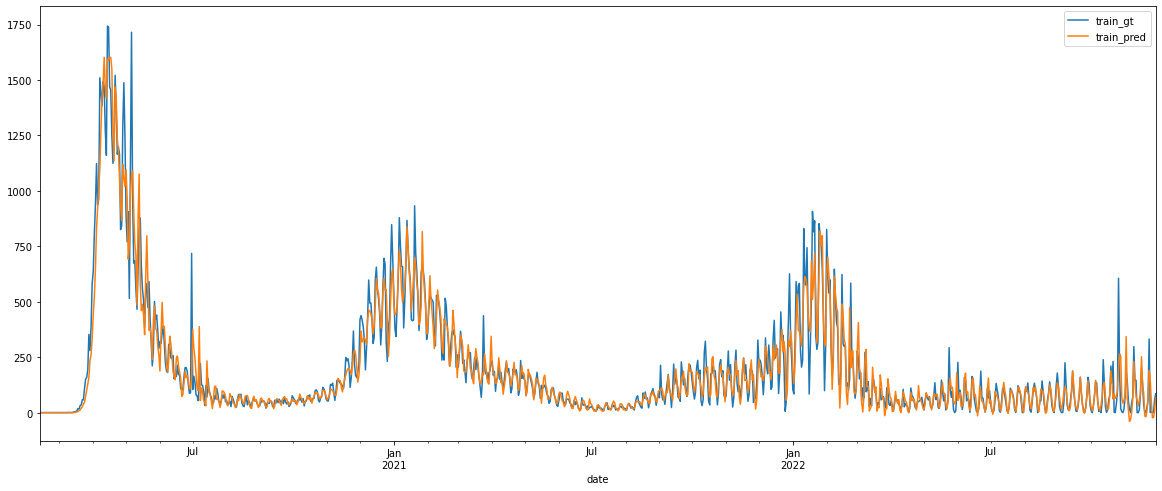

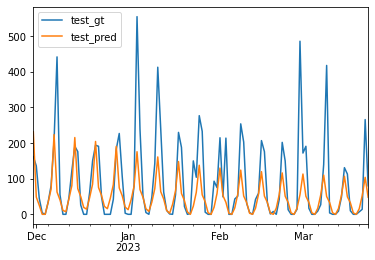

Training Set Metrics:
R-squared: 0.9110766552938006
MAE: 45.18343862292853
MASE: 0.6929996069343092

Testing Set Metrics:
R-squared: 0.2650918119813357
MAE: 52.947939465621
MASE: 0.5978334492021555


In [973]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred - 20
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [738]:
east_auto = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(east_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12522.332, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14336.039, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12503.370, Time=0.89 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13141.476, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14779.862, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=12520.988, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=12464.954, Time=7.61 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=12466.925, Time=4.89 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=12484.035, Time=2.09 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=13635.076, Time=3.61 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=12447.506, Time=7.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=12503.829, Time=2.21 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=12449.629, Time=6.80 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=12479.237, Time=2.50 sec
 ARIM

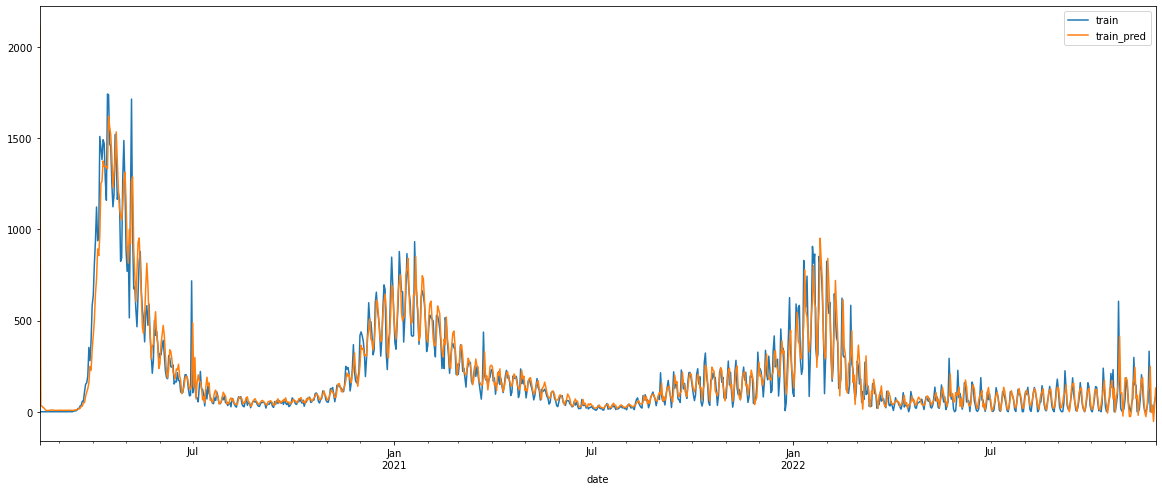

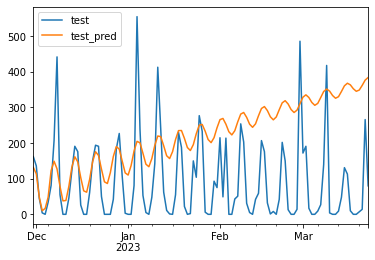

Training Set Metrics:
R-squared: 0.8422756038299742
MAE: 51.15093194778814
MASE: 0.7845258531552477

Testing Set Metrics:
R-squared: -1.7356426363629658
MAE: 154.91392976739783
MASE: 1.7491281038884847


In [853]:
train_pred=east_auto.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=east_auto.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [742]:
east_auto2 = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(east_auto2.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=13079.830, Time=0.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=13265.153, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12986.921, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=13266.339, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=12720.435, Time=2.10 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=12733.353, Time=1.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12645.987, Time=1.83 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=12921.628, Time=0.80 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.21 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=12627.255, Time=2.78 sec
 ARIMA(3,1,0)(1,1,0)[12]           

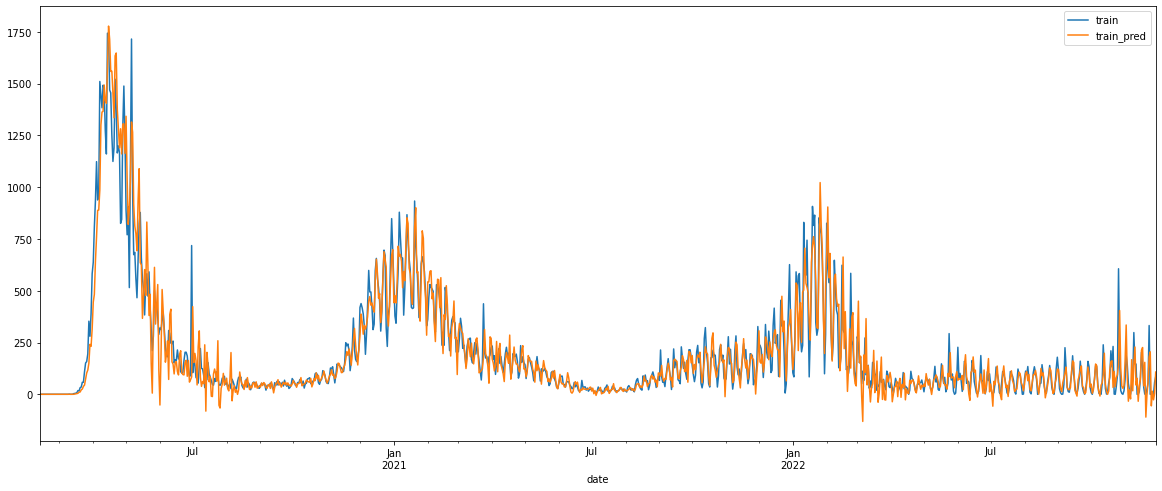

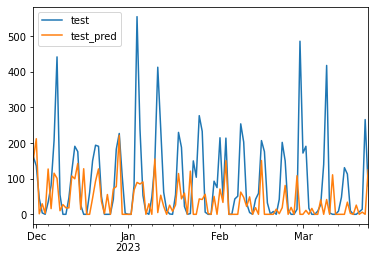

Training Set Metrics:
R-squared: 0.8779284256736539
MAE: 56.39945521573626
MASE: 0.8650249181340672

Testing Set Metrics:
R-squared: -0.08174973114013762
MAE: 71.84976120928278
MASE: 0.8112532990256748


In [854]:
train_pred=east_auto2.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=east_auto2.predict(n_periods=len(east_test))
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [748]:
n_periods=12
forecast, conf_int = east_auto2.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    153.952391
2022-12-01    212.234825
2022-12-02      1.402915
2022-12-03     29.611238
2022-12-04      2.837616
2022-12-05    127.272862
2022-12-06     15.997262
2022-12-07    115.445788
2022-12-08    101.063246
2022-12-09     10.106813
2022-12-10     27.238273
2022-12-11     18.235296
Freq: D, dtype: float64
Confidence Interval: [[ -53.47999588  361.38477812]
 [ -19.46090659  443.93055725]
 [-239.10471124  241.91054176]
 [-217.35694919  276.57942526]
 [-252.08725329  257.76248467]
 [-133.37130206  387.91702663]
 [-260.62806933  292.62259236]
 [-195.88133907  426.77291574]
 [-232.29869474  434.42518719]
 [-329.73690073  349.95052768]
 [-317.74128224  372.21782737]
 [-332.63085301  369.10144424]]


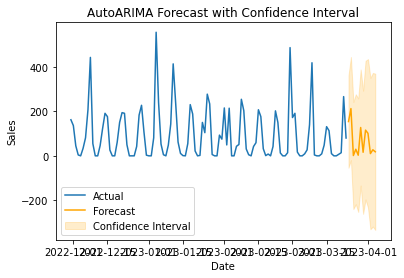

In [749]:
forecast_index = pd.date_range(east_test.index[-1], periods=n_periods + 1, freq=east_test.index.freq)[-n_periods:]

plt.plot(east_test.index, east_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### midwest

In [943]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(midwest_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35808D+00    |proj g|=  1.19936D-01


 This problem is unconstrained.



At iterate    5    f=  6.29640D+00    |proj g|=  3.55602D-02

At iterate   10    f=  6.27726D+00    |proj g|=  2.61106D-03

At iterate   15    f=  6.20385D+00    |proj g|=  4.11091D-02

At iterate   20    f=  6.20146D+00    |proj g|=  5.03584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.036D-05   6.201D+00
  F =   6.2014572046562115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34182D+00    |proj g|=  1.22090D-01

At iterate    5    f=  6.28645D+00    |proj g|=  1.40442D-02

At iterate   10    f=  6.27474D+00    |proj g|=  7.11532D-03

At iterate   15    f=  6.22620D+00    |proj g|=  2.46793D-02

At iterate   20    f=  6.20254D+00    |proj g|=  9.14922D-04

At iterate   25    f=  6.20168D+00    |proj g|=  4.95518D-03

At iterate   30    f=  6.20149D+00    |proj g|=  1.24953D-04

At iterate   35    f=  6.20137D+00    |proj g|=  3.72288D-04

At iterate   40    f=  6.20132D+00    |proj g|=  5.60993D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     76      2     0     0   4.507D-06   6.201D+00
  F =   6.2013190089514341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.34839D+00    |proj g|=  1.25522D-01


 This problem is unconstrained.



At iterate    5    f=  6.28911D+00    |proj g|=  2.52699D-02

At iterate   10    f=  6.27568D+00    |proj g|=  4.77720D-03

At iterate   15    f=  6.21098D+00    |proj g|=  2.28143D-02

At iterate   20    f=  6.20764D+00    |proj g|=  8.78369D-04

At iterate   25    f=  6.20756D+00    |proj g|=  8.39356D-03

At iterate   30    f=  6.20682D+00    |proj g|=  1.38619D-03

At iterate   35    f=  6.20672D+00    |proj g|=  6.63293D-04

At iterate   40    f=  6.20671D+00    |proj g|=  1.90450D-04

At iterate   45    f=  6.20671D+00    |proj g|=  3.40271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     58   

 This problem is unconstrained.



At iterate    5    f=  6.28954D+00    |proj g|=  2.10123D-02

At iterate   10    f=  6.27508D+00    |proj g|=  2.71256D-03

At iterate   15    f=  6.23808D+00    |proj g|=  2.40261D-02

At iterate   20    f=  6.21388D+00    |proj g|=  5.68712D-02

At iterate   25    f=  6.20316D+00    |proj g|=  1.55109D-03

At iterate   30    f=  6.20154D+00    |proj g|=  7.10515D-03

At iterate   35    f=  6.20123D+00    |proj g|=  6.56176D-05

At iterate   40    f=  6.20123D+00    |proj g|=  9.31655D-04

At iterate   45    f=  6.20116D+00    |proj g|=  3.71889D-03

At iterate   50    f=  6.20113D+00    |proj g|=  4.81377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86750D+00    |proj g|=  1.12646D+00

At iterate    5    f=  6.28241D+00    |proj g|=  6.06705D-02

At iterate   10    f=  6.26077D+00    |proj g|=  2.84879D-02

At iterate   15    f=  6.18480D+00    |proj g|=  3.75033D-02

At iterate   20    f=  6.16059D+00    |proj g|=  8.38803D-03

At iterate   25    f=  6.15124D+00    |proj g|=  3.91298D-02

At iterate   30    f=  6.09807D+00    |proj g|=  7.26685D-03

At iterate   35    f=  6.09795D+00    |proj g|=  9.06564D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.28055D+00    |proj g|=  4.71267D-02

At iterate   10    f=  6.23186D+00    |proj g|=  7.60909D-02

At iterate   15    f=  6.16316D+00    |proj g|=  3.15461D-02

At iterate   20    f=  6.15745D+00    |proj g|=  4.66582D-03

At iterate   25    f=  6.12923D+00    |proj g|=  4.37507D-02

At iterate   30    f=  6.09863D+00    |proj g|=  8.07317D-03

At iterate   35    f=  6.09835D+00    |proj g|=  1.14470D-04

At iterate   40    f=  6.09823D+00    |proj g|=  7.30327D-03

At iterate   45    f=  6.09793D+00    |proj g|=  6.13599D-03

At iterate   50    f=  6.09783D+00    |proj g|=  7.21862D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.28603D+00    |proj g|=  5.92035D-02

At iterate   10    f=  6.24642D+00    |proj g|=  4.65310D-02

At iterate   15    f=  6.17661D+00    |proj g|=  4.34903D-02

At iterate   20    f=  6.16296D+00    |proj g|=  1.12788D-02

At iterate   25    f=  6.15106D+00    |proj g|=  4.63878D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     50      1     0     0   2.940D-02   6.134D+00
  F =   6.1341709068585573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84052D+00    |proj g|=  1.11879D+00


 This problem is unconstrained.



At iterate    5    f=  6.28189D+00    |proj g|=  4.47510D-02

At iterate   10    f=  6.24946D+00    |proj g|=  3.81213D-02

At iterate   15    f=  6.17172D+00    |proj g|=  3.41133D-02

At iterate   20    f=  6.15856D+00    |proj g|=  4.13283D-03

At iterate   25    f=  6.15612D+00    |proj g|=  2.06629D-02

At iterate   30    f=  6.12392D+00    |proj g|=  3.02920D-02

At iterate   35    f=  6.09802D+00    |proj g|=  1.15950D-02

At iterate   40    f=  6.09712D+00    |proj g|=  3.24322D-04

At iterate   45    f=  6.09708D+00    |proj g|=  6.02964D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     56   

 This problem is unconstrained.



At iterate    5    f=  6.28130D+00    |proj g|=  1.61624D-02

At iterate   10    f=  6.26879D+00    |proj g|=  1.49419D-02

At iterate   15    f=  6.24342D+00    |proj g|=  4.01599D-02

At iterate   20    f=  6.18189D+00    |proj g|=  3.97017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   1.312D-05   6.182D+00
  F =   6.1818573769164678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.27228D+00    |proj g|=  1.71050D-02

At iterate   10    f=  6.26328D+00    |proj g|=  2.75042D-03

At iterate   15    f=  6.21332D+00    |proj g|=  5.26156D-02

At iterate   20    f=  6.18404D+00    |proj g|=  8.41868D-03

At iterate   25    f=  6.18205D+00    |proj g|=  6.78544D-05

At iterate   30    f=  6.18204D+00    |proj g|=  3.65326D-03

At iterate   35    f=  6.18185D+00    |proj g|=  5.19075D-03

At iterate   40    f=  6.18171D+00    |proj g|=  2.85940D-03

At iterate   45    f=  6.18161D+00    |proj g|=  4.61983D-03

At iterate   50    f=  6.18149D+00    |proj g|=  2.81751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.27213D+00    |proj g|=  1.94623D-02

At iterate   10    f=  6.26577D+00    |proj g|=  3.51706D-03

At iterate   15    f=  6.21446D+00    |proj g|=  5.38225D-02
  ys=-2.708E-03  -gs= 4.861E-03 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     46      1     1     0   5.396D-02   6.214D+00
  F =   6.2135904721663673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33802D+00    |proj g|=  1.42407D-01


 This problem is unconstrained.



At iterate    5    f=  6.28015D+00    |proj g|=  2.37723D-02

At iterate   10    f=  6.26448D+00    |proj g|=  5.43672D-03

At iterate   15    f=  6.23090D+00    |proj g|=  1.95859D-01

At iterate   20    f=  6.18995D+00    |proj g|=  5.74759D-02

At iterate   25    f=  6.18296D+00    |proj g|=  6.67606D-03

At iterate   30    f=  6.18165D+00    |proj g|=  1.25634D-03

At iterate   35    f=  6.18164D+00    |proj g|=  6.11351D-04

At iterate   40    f=  6.18159D+00    |proj g|=  3.83613D-03

At iterate   45    f=  6.18134D+00    |proj g|=  4.33903D-03

At iterate   50    f=  6.18121D+00    |proj g|=  3.36950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.26075D+00    |proj g|=  8.08979D-02

At iterate   10    f=  6.22328D+00    |proj g|=  8.13058D-03

At iterate   15    f=  6.22015D+00    |proj g|=  4.78688D-03

At iterate   20    f=  6.20812D+00    |proj g|=  3.10421D-02

At iterate   25    f=  6.20114D+00    |proj g|=  2.96634D-04

At iterate   30    f=  6.20108D+00    |proj g|=  4.43586D-03

At iterate   35    f=  6.20090D+00    |proj g|=  3.74873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     40      1     0     0   3.749D-05   6.201D+00
  F =   6.2009028282638887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23722D+00    |proj g|=  1.71251D+00

At iterate    5    f=  6.25359D+00    |proj g|=  6.81194D-02

At iterate   10    f=  6.22196D+00    |proj g|=  3.62361D-03

At iterate   15    f=  6.22022D+00    |proj g|=  3.85600D-03

At iterate   20    f=  6.21151D+00    |proj g|=  2.11446D-02

At iterate   25    f=  6.20050D+00    |proj g|=  3.28698D-03

At iterate   30    f=  6.20047D+00    |proj g|=  2.03816D-03

At iterate   35    f=  6.20026D+00    |proj g|=  7.00572D-04

At iterate   40    f=  6.20019D+00    |proj g|=  2.20635D-03

At iterate   45    f=  6.19990D+00    |proj g|=  6.68884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.25931D+00    |proj g|=  7.11581D-02

At iterate   10    f=  6.22183D+00    |proj g|=  6.09484D-03

At iterate   15    f=  6.22046D+00    |proj g|=  4.33059D-03

At iterate   20    f=  6.21915D+00    |proj g|=  6.24234D-03

At iterate   25    f=  6.21502D+00    |proj g|=  6.98639D-02

At iterate   30    f=  6.20126D+00    |proj g|=  3.16456D-03

At iterate   35    f=  6.20124D+00    |proj g|=  1.07088D-03

At iterate   40    f=  6.20095D+00    |proj g|=  1.50209D-02

At iterate   45    f=  6.20045D+00    |proj g|=  5.77281D-04

At iterate   50    f=  6.20044D+00    |proj g|=  1.02977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.25324D+00    |proj g|=  6.56448D-02

At iterate   10    f=  6.22148D+00    |proj g|=  5.31443D-03

At iterate   15    f=  6.22003D+00    |proj g|=  3.32090D-03

At iterate   20    f=  6.21340D+00    |proj g|=  4.15310D-02

At iterate   25    f=  6.20075D+00    |proj g|=  4.89532D-03

At iterate   30    f=  6.20064D+00    |proj g|=  4.32894D-04

At iterate   35    f=  6.20049D+00    |proj g|=  9.29909D-03

At iterate   40    f=  6.19996D+00    |proj g|=  4.43255D-03

At iterate   45    f=  6.19994D+00    |proj g|=  1.76750D-04

At iterate   50    f=  6.19992D+00    |proj g|=  2.53880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [944]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
4   1  2  1  1  12476.215746
5   1  2  1  2  12477.958708
7   1  2  2  2  12478.433090
6   1  2  2  1  12552.245334
8   2  1  1  1  12647.716478
9   2  1  1  2  12648.966171
11  2  1  2  2  12650.398913
0   1  1  1  1  12685.778526
1   1  1  1  2  12687.496054
13  2  2  1  2  12688.591054
12  2  2  1  1  12688.645381
3   1  1  2  2  12689.105905
14  2  2  2  1  12689.708692
15  2  2  2  2  12690.639290
2   1  1  2  1  12698.509301
10  2  1  2  1  12714.578925

In [974]:
model=sm.tsa.statespace.SARIMAX(midwest_train,order=(1, 1, 2),seasonal_order=(1,1,1,7))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86750D+00    |proj g|=  1.12646D+00

At iterate    5    f=  6.28241D+00    |proj g|=  6.06705D-02


 This problem is unconstrained.



At iterate   10    f=  6.26077D+00    |proj g|=  2.84879D-02

At iterate   15    f=  6.18480D+00    |proj g|=  3.75033D-02

At iterate   20    f=  6.16059D+00    |proj g|=  8.38803D-03

At iterate   25    f=  6.15124D+00    |proj g|=  3.91298D-02

At iterate   30    f=  6.09807D+00    |proj g|=  7.26685D-03

At iterate   35    f=  6.09795D+00    |proj g|=  9.06564D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     42      1     0     0   9.066D-06   6.098D+00
  F =   6.0979529091558868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


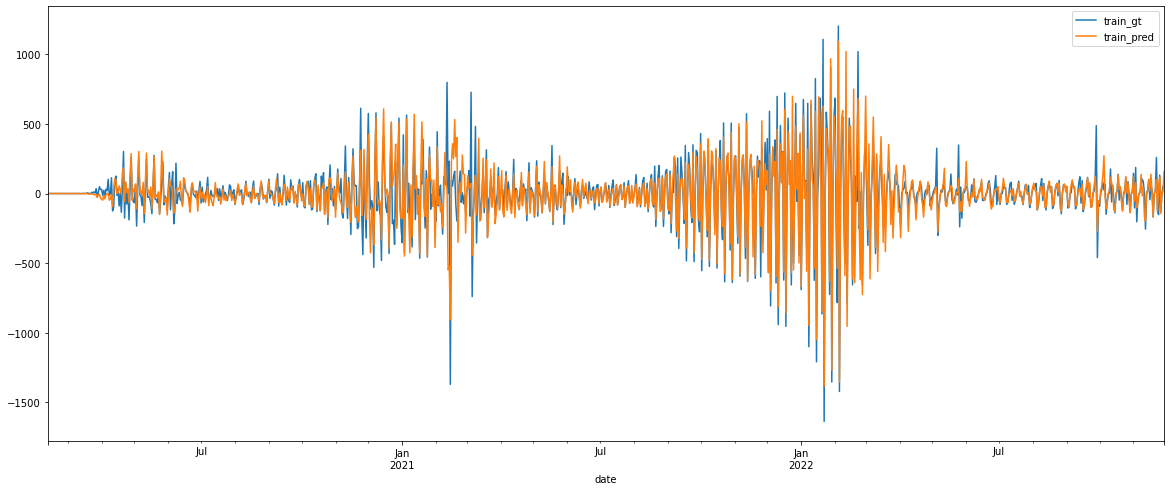

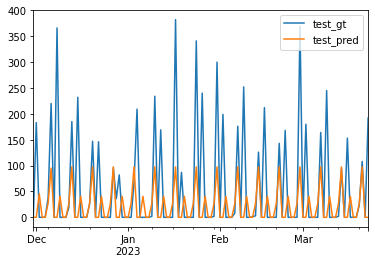

Training Set Metrics:
R-squared: 0.7807876047724721
MAE: 64.38288516777872
MASE: 0.28828831827444357

Testing Set Metrics:
R-squared: 0.040667591863177255
MAE: 52.60256344584722
MASE: 0.474237248235259


In [980]:
train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 0.8
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [750]:
midwest_auto = auto_arima(midwest_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(midwest_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15553.452, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14927.211, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15348.416, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=14796.238, Time=1.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15340.365, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=14659.558, Time=1.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14855.256, Time=0.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.57 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.58 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=14435.877, Time=6.28 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

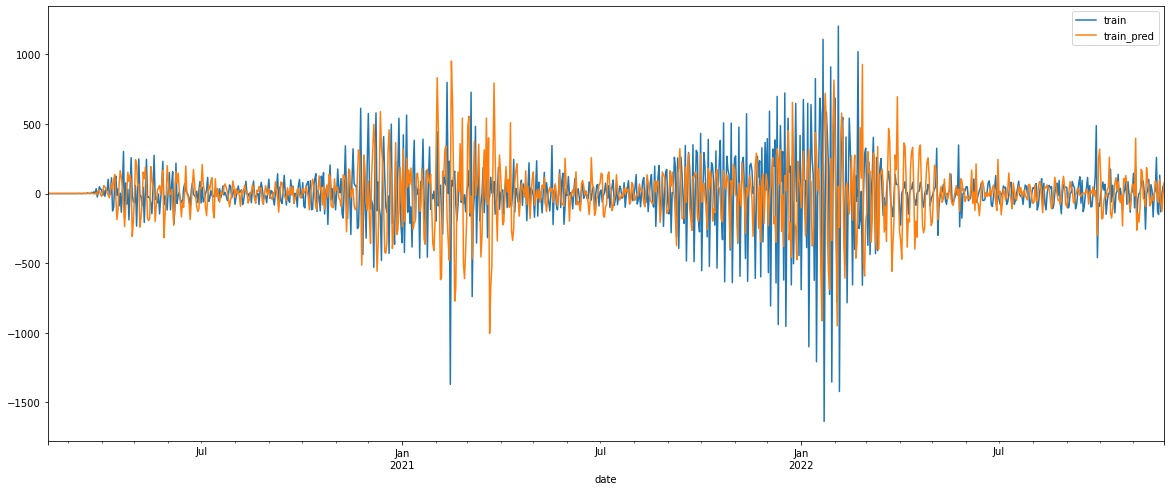

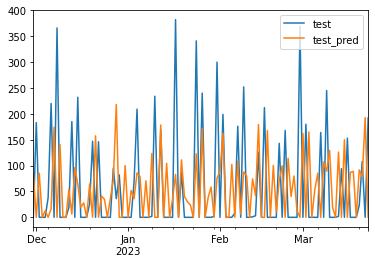

Training Set Metrics:
R-squared: -0.41841331834673223
MAE: 178.28968354651724
MASE: 0.7983306883710676

Testing Set Metrics:
R-squared: -0.3277299115587402
MAE: 81.15063048741717
MASE: 0.7316117157394401


In [857]:
train_pred=midwest_auto.fittedvalues()
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=midwest_auto.predict(n_periods=len(midwest_test))
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [755]:
n_periods=12
forecast, conf_int = midwest_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30     83.609360
2022-12-01      0.000000
2022-12-02     85.103551
2022-12-03      0.000000
2022-12-04     12.786727
2022-12-05      0.000000
2022-12-06     16.385359
2022-12-07    174.134904
2022-12-08      0.000000
2022-12-09    140.415599
2022-12-10      0.000000
2022-12-11      0.000000
Freq: D, dtype: float64
Confidence Interval: [[-477.93983739  645.15855721]
 [-748.64360468  515.31223365]
 [-554.73641013  724.94351304]
 [-733.16756123  645.99786607]
 [-687.51724501  713.09069989]
 [-735.83684537  666.91955256]
 [-692.71862074  725.48933933]
 [-573.16271213  921.43251946]
 [-881.86449174  614.2640929 ]
 [-608.29947063  889.13066898]
 [-882.69842675  649.2178523 ]
 [-789.05163691  768.86327499]]


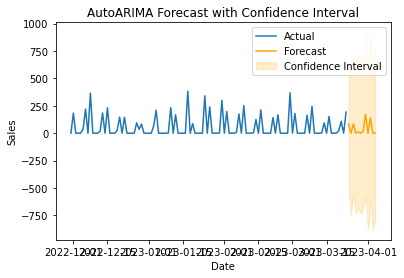

In [756]:
forecast_index = pd.date_range(midwest_test.index[-1], periods=n_periods + 1, freq=midwest_test.index.freq)[-n_periods:]

plt.plot(midwest_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### south

In [947]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(south_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93379D+00    |proj g|=  1.00299D-01



 This problem is unconstrained.


At iterate    5    f=  6.88383D+00    |proj g|=  2.89472D-02

At iterate   10    f=  6.87410D+00    |proj g|=  5.13832D-03

At iterate   15    f=  6.86006D+00    |proj g|=  2.16225D-02

At iterate   20    f=  6.79515D+00    |proj g|=  7.06874D-02

At iterate   25    f=  6.78956D+00    |proj g|=  2.65165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   3.376D-06   6.790D+00
  F =   6.7895549541794935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate    5    f=  6.88246D+00    |proj g|=  1.56798D-02

At iterate   10    f=  6.87027D+00    |proj g|=  1.47583D-03

At iterate   15    f=  6.85885D+00    |proj g|=  1.92454D-02

At iterate   20    f=  6.79253D+00    |proj g|=  8.91727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   1.949D-05   6.792D+00
  F =   6.7924354944200216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.88889D+00    |proj g|=  3.30690D-02

At iterate   10    f=  6.86911D+00    |proj g|=  1.63821D-02

At iterate   15    f=  6.86541D+00    |proj g|=  1.70157D-03

At iterate   20    f=  6.85915D+00    |proj g|=  1.74505D-02

At iterate   25    f=  6.82355D+00    |proj g|=  5.97363D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     45      1     0     0   5.963D-03   6.824D+00
  F =   6.8235513357381299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92221D+00    |proj g|=  1.06051D-01


 This problem is unconstrained.



At iterate    5    f=  6.88271D+00    |proj g|=  2.47429D-02

At iterate   10    f=  6.87336D+00    |proj g|=  9.05533D-03

At iterate   15    f=  6.86795D+00    |proj g|=  8.04583D-03

At iterate   20    f=  6.83692D+00    |proj g|=  1.04176D-01

At iterate   25    f=  6.79128D+00    |proj g|=  1.86421D-02

At iterate   30    f=  6.77821D+00    |proj g|=  2.69390D-02

At iterate   35    f=  6.77567D+00    |proj g|=  7.68157D-04

At iterate   40    f=  6.77566D+00    |proj g|=  5.24331D-04

At iterate   45    f=  6.77566D+00    |proj g|=  8.85550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     75   

 This problem is unconstrained.



At iterate    5    f=  6.86748D+00    |proj g|=  8.15003D-02

At iterate   10    f=  6.73413D+00    |proj g|=  3.39379D-02

At iterate   15    f=  6.72648D+00    |proj g|=  1.19283D-02

At iterate   20    f=  6.71969D+00    |proj g|=  3.75170D-03

At iterate   25    f=  6.71499D+00    |proj g|=  1.39724D-02

At iterate   30    f=  6.70103D+00    |proj g|=  4.78923D-02

At iterate   35    f=  6.66852D+00    |proj g|=  3.65624D-03

At iterate   40    f=  6.66850D+00    |proj g|=  4.06381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     49      1     0     0   4.064D-04   6.669D+00
  F =   6.66850385203

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40008D+00    |proj g|=  1.00366D+00

At iterate    5    f=  6.87086D+00    |proj g|=  6.47133D-02

At iterate   10    f=  6.73179D+00    |proj g|=  3.06529D-02

At iterate   15    f=  6.72523D+00    |proj g|=  6.46184D-03

At iterate   20    f=  6.71549D+00    |proj g|=  2.21467D-02

At iterate   25    f=  6.68541D+00    |proj g|=  1.40396D-02
  ys=-1.294E-01  -gs= 1.836E-02 BFGS update SKIPPED
  ys=-4.147E-10  -gs= 1.887E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  6.67068D+00    |proj g|=  1.22378D-02

At iterate   35    f=  6.67042D+00    |proj g|=  9.25342D-03

At iterate   40    f=  6.67005D+00    |proj g|=  9.29897D-03

At iterate   45    f=  6.66969D+00    |proj g|=  1.03584D-02

At iterate   50    f=  6.66914D+00    |proj g|=  2.09657D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    104      2     2     0   2.097D-02   6.669D+00
  F =   6.6691397246857873     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
1 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.87341D+00    |proj g|=  8.83673D-02

At iterate   10    f=  6.74233D+00    |proj g|=  4.52011D-02

At iterate   15    f=  6.71701D+00    |proj g|=  1.70029D-02

At iterate   20    f=  6.71382D+00    |proj g|=  8.32036D-03

At iterate   25    f=  6.71101D+00    |proj g|=  8.97007D-03

At iterate   30    f=  6.68058D+00    |proj g|=  8.06774D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  6.65660D+00    |proj g|=  6.26468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     58      1     0     0   6.265D-03   6.657D+00
  F =   6.6566041161430540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.43756D+00    |proj g|=  1.06374D+00


 This problem is unconstrained.



At iterate    5    f=  6.86738D+00    |proj g|=  6.21437D-02

At iterate   10    f=  6.73706D+00    |proj g|=  3.15768D-02

At iterate   15    f=  6.72255D+00    |proj g|=  5.21348D-03

At iterate   20    f=  6.72083D+00    |proj g|=  1.51396D-02

At iterate   25    f=  6.71194D+00    |proj g|=  2.91303D-02

At iterate   30    f=  6.68250D+00    |proj g|=  2.43651D-02

At iterate   35    f=  6.67129D+00    |proj g|=  3.29084D-02

At iterate   40    f=  6.66905D+00    |proj g|=  3.22242D-03

At iterate   45    f=  6.66859D+00    |proj g|=  3.39967D-03

At iterate   50    f=  6.66853D+00    |proj g|=  1.31145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.85970D+00    |proj g|=  7.60395D-03

At iterate   10    f=  6.85307D+00    |proj g|=  2.85852D-03

At iterate   15    f=  6.84990D+00    |proj g|=  1.90237D-02

At iterate   20    f=  6.78743D+00    |proj g|=  6.91744D-02

At iterate   25    f=  6.75191D+00    |proj g|=  9.87765D-03

At iterate   30    f=  6.75184D+00    |proj g|=  9.37119D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   2.222D-05   6.752D+00
  F =   6.7518385225162323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.86769D+00    |proj g|=  2.58255D-02

At iterate   10    f=  6.85170D+00    |proj g|=  8.25574D-03

At iterate   15    f=  6.84517D+00    |proj g|=  1.08296D-02

At iterate   20    f=  6.76608D+00    |proj g|=  2.79792D-02

At iterate   25    f=  6.74197D+00    |proj g|=  5.02159D-02

At iterate   30    f=  6.73664D+00    |proj g|=  1.64390D-03

At iterate   35    f=  6.73522D+00    |proj g|=  1.53724D-03

At iterate   40    f=  6.73514D+00    |proj g|=  7.05378D-04

At iterate   45    f=  6.73510D+00    |proj g|=  1.06624D-03

At iterate   50    f=  6.73510D+00    |proj g|=  2.89822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.87097D+00    |proj g|=  4.98394D-02

At iterate   10    f=  6.84935D+00    |proj g|=  2.24133D-02

At iterate   15    f=  6.84293D+00    |proj g|=  2.52752D-03

At iterate   20    f=  6.84194D+00    |proj g|=  5.35323D-03

At iterate   25    f=  6.79565D+00    |proj g|=  1.24973D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     48      1     0     0   1.252D-01   6.796D+00
  F =   6.7956523353710052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93216D+00    |proj g|=  1.25031D-01


 This problem is unconstrained.



At iterate    5    f=  6.86516D+00    |proj g|=  2.48776D-02

At iterate   10    f=  6.85225D+00    |proj g|=  5.82505D-03

At iterate   15    f=  6.84602D+00    |proj g|=  2.06333D-02

At iterate   20    f=  6.83806D+00    |proj g|=  2.91262D-02

At iterate   25    f=  6.81941D+00    |proj g|=  1.54861D-01

At iterate   30    f=  6.78562D+00    |proj g|=  2.28047D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  6.78176D+00    |proj g|=  2.96316D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     61      1     0     0   2.963D-02   6.782D+00
  F =   6.7817620735720316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40603D+00    |proj g|=  9.92114D-01


 This problem is unconstrained.



At iterate    5    f=  6.81453D+00    |proj g|=  4.50392D-02

At iterate   10    f=  6.80207D+00    |proj g|=  4.13507D-03

At iterate   15    f=  6.79379D+00    |proj g|=  5.60759D-02

At iterate   20    f=  6.75773D+00    |proj g|=  1.49152D-01

At iterate   25    f=  6.71577D+00    |proj g|=  7.91407D-03

At iterate   30    f=  6.71387D+00    |proj g|=  2.27851D-02

At iterate   35    f=  6.71114D+00    |proj g|=  4.02736D-03

At iterate   40    f=  6.70647D+00    |proj g|=  3.71769D-02

At iterate   45    f=  6.67449D+00    |proj g|=  3.83778D-02

At iterate   50    f=  6.66853D+00    |proj g|=  2.71103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31648D+00    |proj g|=  8.55988D-01

At iterate    5    f=  6.81178D+00    |proj g|=  4.48173D-02

At iterate   10    f=  6.80171D+00    |proj g|=  1.46157D-02

At iterate   15    f=  6.79855D+00    |proj g|=  1.79651D-02

At iterate   20    f=  6.74437D+00    |proj g|=  8.04310D-02

At iterate   25    f=  6.71166D+00    |proj g|=  3.49512D-03

At iterate   30    f=  6.70989D+00    |proj g|=  2.93887D-02

At iterate   35    f=  6.66849D+00    |proj g|=  8.30127D-02

At iterate   40    f=  6.65684D+00    |proj g|=  3.66088D-02

At iterate   45    f=  6.65345D+00    |proj g|=  4.98855D-03

At iterate   50    f=  6.65201D+00    |proj g|=  2.52856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.82018D+00    |proj g|=  4.12106D-02

At iterate   10    f=  6.79754D+00    |proj g|=  2.21803D-02

At iterate   15    f=  6.79387D+00    |proj g|=  2.91379D-03

At iterate   20    f=  6.79186D+00    |proj g|=  5.43950D-02

At iterate   25    f=  6.76957D+00    |proj g|=  1.09399D-01

At iterate   30    f=  6.71828D+00    |proj g|=  9.46262D-03

At iterate   35    f=  6.71461D+00    |proj g|=  1.09855D-02

At iterate   40    f=  6.68875D+00    |proj g|=  4.24595D-02

At iterate   45    f=  6.67089D+00    |proj g|=  3.78075D-02

At iterate   50    f=  6.66243D+00    |proj g|=  8.75381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.81185D+00    |proj g|=  3.70821D-02

At iterate   10    f=  6.80009D+00    |proj g|=  3.77967D-03

At iterate   15    f=  6.79232D+00    |proj g|=  2.02607D-02

At iterate   20    f=  6.76596D+00    |proj g|=  1.93095D-01

At iterate   25    f=  6.70726D+00    |proj g|=  1.36905D-02

At iterate   30    f=  6.70613D+00    |proj g|=  9.97210D-03

At iterate   35    f=  6.70165D+00    |proj g|=  1.15792D-02
  ys=-5.266E+00  -gs= 5.578E-02 BFGS update SKIPPED
  ys=-1.050E+10  -gs= 1.198E+03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


LinAlgError: LU decomposition error.

In [948]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
13  2  2  1  2  13612.717431
6   1  2  2  1  13620.098813
14  2  2  2  1  13634.007828
4   1  2  1  1  13642.421874
12  2  2  1  1  13644.467973
5   1  2  1  2  13645.721597
7   1  2  2  2  13646.473567
9   2  1  1  2  13780.541768
8   2  1  1  1  13812.757940
3   1  1  2  2  13863.437148
11  2  1  2  2  13877.921678
0   1  1  1  1  13887.850326
1   1  1  1  2  13895.738151
10  2  1  2  1  13904.313373
2   1  1  2  1  13959.338930

In [981]:
model=sm.tsa.statespace.SARIMAX(south_train,order=(2, 1, 2),seasonal_order=(1,1,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31648D+00    |proj g|=  8.55988D-01

At iterate    5    f=  6.81178D+00    |proj g|=  4.48173D-02

At iterate   10    f=  6.80171D+00    |proj g|=  1.46157D-02

At iterate   15    f=  6.79855D+00    |proj g|=  1.79651D-02

At iterate   20    f=  6.74437D+00    |proj g|=  8.04310D-02

At iterate   25    f=  6.71166D+00    |proj g|=  3.49512D-03

At iterate   30    f=  6.70989D+00    |proj g|=  2.93887D-02

At iterate   35    f=  6.66849D+00    |proj g|=  8.30127D-02

At iterate   40    f=  6.65684D+00    |proj g|=  3.66088D-02

At iterate   45    f=  6.65345D+00    |proj g|=  4.98855D-03

At iterate   50    f=  6.65201D+00    |proj g|=  2.52856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

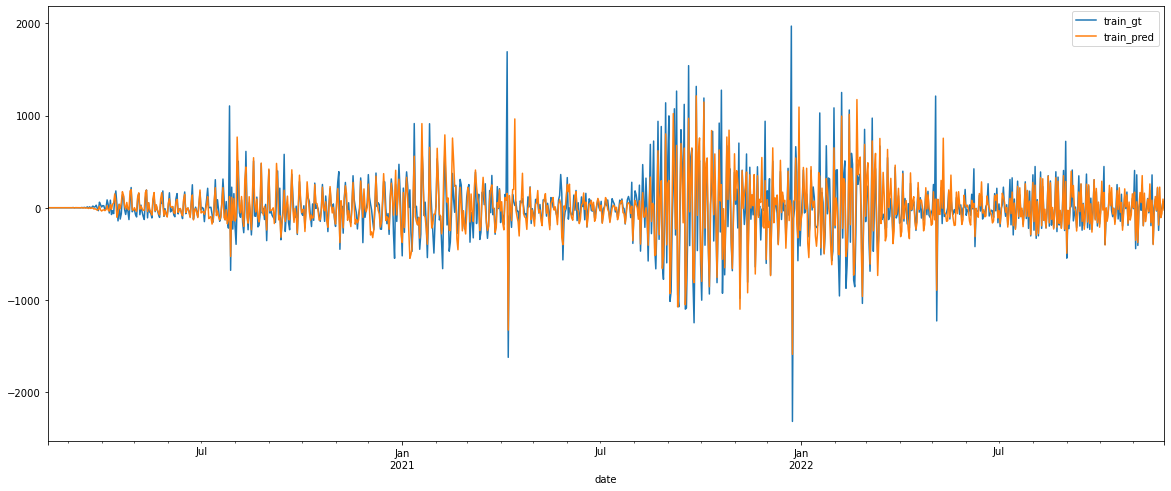

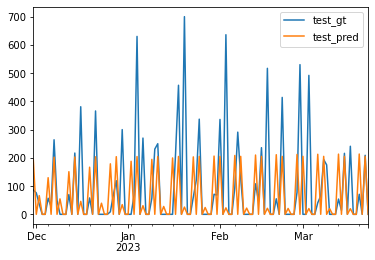

Training Set Metrics:
R-squared: 0.6543891592051905
MAE: 113.91356508511436
MASE: 0.35508760720612614

Testing Set Metrics:
R-squared: -0.009265958566972099
MAE: 85.77550938076867
MASE: 0.5364529864969482


In [985]:
train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
#test_pred = test_pred * 0.8
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [778]:
south_auto = auto_arima(south_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(south_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16293.650, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15650.632, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=16119.994, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15460.904, Time=1.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15768.562, Time=0.77 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15346.926, Time=2.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15580.342, Time=1.13 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=15193.024, Time=2.79 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

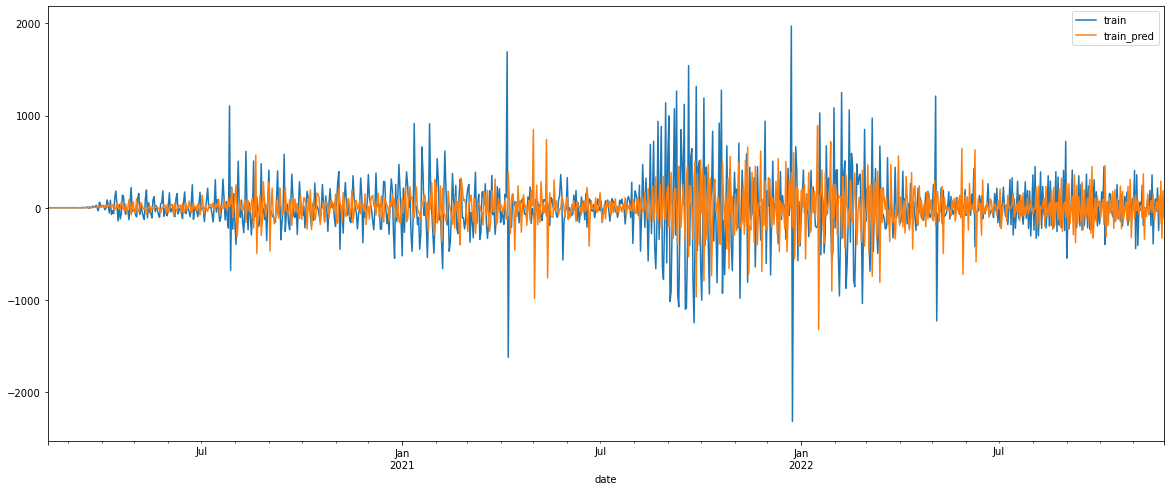

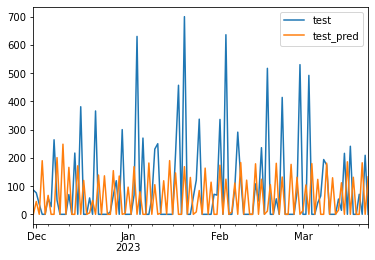

Training Set Metrics:
R-squared: -0.7089082411331655
MAE: 285.42112632938824
MASE: 0.8897053192800456

Testing Set Metrics:
R-squared: -0.31625556700080915
MAE: 118.48518514517453
MASE: 0.741024237403405


In [860]:
train_pred=south_auto.fittedvalues()
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=south_auto.predict(n_periods=len(south_test))
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [801]:
n_periods=12
forecast, conf_int = south_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30      0.000000
2022-12-01     45.314749
2022-12-02      0.000000
2022-12-03    189.867562
2022-12-04      0.000000
2022-12-05     67.034426
2022-12-06      0.000000
2022-12-07      0.000000
2022-12-08    200.786211
2022-12-09      0.000000
2022-12-10    248.348355
2022-12-11      0.000000
Freq: D, dtype: float64
Confidence Interval: [[ -908.91967578   801.60141343]
 [ -817.15099301   907.78049001]
 [-1027.48555985   746.90094748]
 [ -703.61726997  1083.35239418]
 [-1034.81151823   762.610228  ]
 [ -862.10687677   996.17572928]
 [-1054.79557965   949.4253603 ]
 [-1028.76082059  1012.4275762 ]
 [ -843.28311174  1244.8555337 ]
 [-1242.57384938   869.90662625]
 [ -822.79709555  1319.49380618]
 [-1340.9679849    853.78271021]]


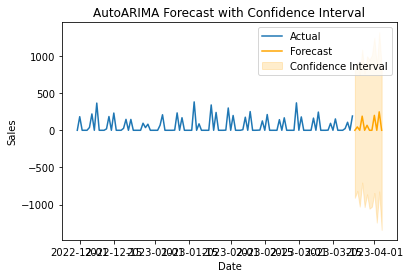

In [802]:
forecast_index = pd.date_range(south_test.index[-1], periods=n_periods + 1, freq=south_test.index.freq)[-n_periods:]

plt.plot(south_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### west

In [959]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(west_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13928D+00    |proj g|=  1.46527D-01


 This problem is unconstrained.



At iterate    5    f=  6.09376D+00    |proj g|=  1.19625D-02

At iterate   10    f=  6.07080D+00    |proj g|=  7.98316D-03

At iterate   15    f=  5.99093D+00    |proj g|=  4.83299D-02

At iterate   20    f=  5.98725D+00    |proj g|=  9.66608D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   1.115D-06   5.987D+00
  F =   5.9872455254910815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.08891D+00    |proj g|=  3.71789D-02

At iterate   10    f=  6.07341D+00    |proj g|=  1.73466D-02

At iterate   15    f=  5.98909D+00    |proj g|=  2.93328D-02

At iterate   20    f=  5.98761D+00    |proj g|=  5.50392D-04

At iterate   25    f=  5.98751D+00    |proj g|=  1.49072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   8.699D-07   5.988D+00
  F =   5.9875085564226591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  6.08896D+00    |proj g|=  2.37889D-02

At iterate   10    f=  6.07842D+00    |proj g|=  3.57688D-03

At iterate   15    f=  6.03539D+00    |proj g|=  5.54948D-02

At iterate   20    f=  5.98674D+00    |proj g|=  4.04857D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  5.98667D+00    |proj g|=  2.69392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     51      2     0     0   2.694D-05   5.987D+00
  F =   5.9866701534535691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12765D+00    |proj g|=  1.41741D-01


 This problem is unconstrained.



At iterate    5    f=  6.09199D+00    |proj g|=  1.11000D-02

At iterate   10    f=  6.07512D+00    |proj g|=  5.85366D-03

At iterate   15    f=  5.98603D+00    |proj g|=  1.11384D-02

At iterate   20    f=  5.98569D+00    |proj g|=  1.90170D-03

At iterate   25    f=  5.98546D+00    |proj g|=  3.98049D-03

At iterate   30    f=  5.98542D+00    |proj g|=  1.15257D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     37      1     0     0   5.280D-06   5.985D+00
  F =   5.9854190756692462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.07181D+00    |proj g|=  7.83394D-02

At iterate   10    f=  5.99156D+00    |proj g|=  8.55158D-02

At iterate   15    f=  5.94484D+00    |proj g|=  2.49820D-02

At iterate   20    f=  5.92774D+00    |proj g|=  5.82675D-02

At iterate   25    f=  5.91843D+00    |proj g|=  1.33402D-02

At iterate   30    f=  5.86788D+00    |proj g|=  1.01114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     40      1     0     0   2.757D-05   5.868D+00
  F =   5.8676516454009908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79244D+00    |proj g|=  1.41897D+00

At iterate    5    f=  6.07210D+00    |proj g|=  6.68825D-02

At iterate   10    f=  5.95304D+00    |proj g|=  8.05853D-02

At iterate   15    f=  5.92726D+00    |proj g|=  4.66559D-03

At iterate   20    f=  5.90423D+00    |proj g|=  7.90116D-02

At iterate   25    f=  5.86895D+00    |proj g|=  1.40232D-03

At iterate   30    f=  5.86766D+00    |proj g|=  3.19294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  6.07784D+00    |proj g|=  8.47734D-02

At iterate   10    f=  5.96204D+00    |proj g|=  8.86152D-02

At iterate   15    f=  5.92862D+00    |proj g|=  1.54439D-02

At iterate   20    f=  5.91897D+00    |proj g|=  1.54796D-02

At iterate   25    f=  5.87369D+00    |proj g|=  6.41288D-02

At iterate   30    f=  5.86033D+00    |proj g|=  9.01834D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     52      1     0     0   6.498D-04   5.860D+00
  F =   5.8602656895659964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82824D+00    |proj g|=  1.47223D+00


 This problem is unconstrained.



At iterate    5    f=  6.07145D+00    |proj g|=  7.92474D-02

At iterate   10    f=  5.96657D+00    |proj g|=  1.25092D-01

At iterate   15    f=  5.92876D+00    |proj g|=  1.14643D-02

At iterate   20    f=  5.91012D+00    |proj g|=  2.48989D-02

At iterate   25    f=  5.86657D+00    |proj g|=  2.66906D-02

At iterate   30    f=  5.86320D+00    |proj g|=  4.21300D-03

At iterate   35    f=  5.85648D+00    |proj g|=  2.24369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     58      1     0     0   6.504D-03   5.854D+00
  F =   5.8539740754570238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.14488D+00    |proj g|=  1.28072D-01


 This problem is unconstrained.



At iterate    5    f=  6.07542D+00    |proj g|=  1.38305D-02

At iterate   10    f=  6.05755D+00    |proj g|=  1.20227D-02

At iterate   15    f=  5.97239D+00    |proj g|=  1.38023D-01

At iterate   20    f=  5.95123D+00    |proj g|=  1.93660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   1.401D-05   5.951D+00
  F =   5.9512330896758243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.06998D+00    |proj g|=  1.46474D-02

At iterate   10    f=  6.05671D+00    |proj g|=  3.66658D-03

At iterate   15    f=  6.01822D+00    |proj g|=  7.00470D-02

At iterate   20    f=  5.95244D+00    |proj g|=  2.96116D-03

At iterate   25    f=  5.95238D+00    |proj g|=  3.03878D-03

At iterate   30    f=  5.95106D+00    |proj g|=  9.72057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     43      1     0     0   2.416D-05   5.951D+00
  F =   5.9510531898051200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.07042D+00    |proj g|=  2.16195D-02

At iterate   10    f=  6.06018D+00    |proj g|=  1.71491D-02

At iterate   15    f=  6.01988D+00    |proj g|=  5.71531D-02

At iterate   20    f=  5.98200D+00    |proj g|=  8.41144D-03

At iterate   25    f=  5.95885D+00    |proj g|=  7.69116D-02

At iterate   30    f=  5.95156D+00    |proj g|=  5.61904D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     40      1     0     0   5.050D-05   5.952D+00
  F =   5.9515628328161707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.07361D+00    |proj g|=  1.63214D-02

At iterate   10    f=  6.05647D+00    |proj g|=  8.14162D-03

At iterate   15    f=  5.98061D+00    |proj g|=  5.56331D-02

At iterate   20    f=  5.95381D+00    |proj g|=  2.19491D-02

At iterate   25    f=  5.95115D+00    |proj g|=  2.00151D-02

At iterate   30    f=  5.95080D+00    |proj g|=  8.09681D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     37      1     0     0   8.097D-05   5.951D+00
  F =   5.9508042847209559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.02624D+00    |proj g|=  6.74744D-02

At iterate   10    f=  6.00666D+00    |proj g|=  1.44433D-02

At iterate   15    f=  5.99862D+00    |proj g|=  3.91282D-03

At iterate   20    f=  5.99614D+00    |proj g|=  5.70827D-03

At iterate   25    f=  5.98419D+00    |proj g|=  9.03123D-03

At iterate   30    f=  5.97810D+00    |proj g|=  1.03242D-01

At iterate   35    f=  5.92834D+00    |proj g|=  1.36230D-01

At iterate   40    f=  5.87787D+00    |proj g|=  4.57731D-02

At iterate   45    f=  5.86815D+00    |proj g|=  2.41194D-04

At iterate   50    f=  5.86815D+00    |proj g|=  1.74931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.02375D+00    |proj g|=  5.94472D-02

At iterate   10    f=  5.99932D+00    |proj g|=  4.78826D-03

At iterate   15    f=  5.99779D+00    |proj g|=  2.99859D-03

At iterate   20    f=  5.98773D+00    |proj g|=  4.13027D-02

At iterate   25    f=  5.94334D+00    |proj g|=  1.93131D-01

At iterate   30    f=  5.87243D+00    |proj g|=  1.67168D-02

At iterate   35    f=  5.86884D+00    |proj g|=  1.11861D-03

At iterate   40    f=  5.86883D+00    |proj g|=  1.65109D-03

At iterate   45    f=  5.86843D+00    |proj g|=  5.43355D-03

At iterate   50    f=  5.86828D+00    |proj g|=  1.82339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.02984D+00    |proj g|=  6.51047D-02

At iterate   10    f=  6.00118D+00    |proj g|=  5.44244D-03

At iterate   15    f=  5.99878D+00    |proj g|=  5.88493D-03

At iterate   20    f=  5.99543D+00    |proj g|=  6.03451D-03

At iterate   25    f=  5.97688D+00    |proj g|=  2.03860D-01

At iterate   30    f=  5.87961D+00    |proj g|=  4.51299D-02

At iterate   35    f=  5.87339D+00    |proj g|=  2.18560D-02

At iterate   40    f=  5.86770D+00    |proj g|=  3.20333D-03

At iterate   45    f=  5.86766D+00    |proj g|=  4.54326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     54   

 This problem is unconstrained.



At iterate    5    f=  6.02462D+00    |proj g|=  6.06288D-02

At iterate   10    f=  6.00169D+00    |proj g|=  1.55405D-02

At iterate   15    f=  5.99751D+00    |proj g|=  5.56867D-03

At iterate   20    f=  5.99575D+00    |proj g|=  1.14434D-02

At iterate   25    f=  5.94735D+00    |proj g|=  8.98860D-02

At iterate   30    f=  5.88991D+00    |proj g|=  2.98929D-02

At iterate   35    f=  5.86992D+00    |proj g|=  1.22912D-02

At iterate   40    f=  5.86842D+00    |proj g|=  1.88919D-04

At iterate   45    f=  5.86839D+00    |proj g|=  4.15750D-03

At iterate   50    f=  5.86785D+00    |proj g|=  8.99460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [960]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
7   1  2  2  2  11981.523010
6   1  2  2  1  11992.383069
4   1  2  1  1  12005.479963
5   1  2  1  2  12007.486885
12  2  2  1  1  12008.494379
14  2  2  2  1  12009.488645
13  2  2  1  2  12010.758772
15  2  2  2  2  12011.879195
8   2  1  1  1  12176.320435
9   2  1  1  2  12177.952720
10  2  1  2  1  12178.994430
11  2  1  2  2  12179.443958
0   1  1  1  1  12247.929854
3   1  1  2  2  12248.196591
2   1  1  2  1  12248.753794
1   1  1  1  2  12250.467489

In [961]:
model=sm.tsa.statespace.SARIMAX(west_train,order=(1, 1, 2),seasonal_order=(2,1,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82824D+00    |proj g|=  1.47223D+00

At iterate    5    f=  6.07145D+00    |proj g|=  7.92474D-02

At iterate   10    f=  5.96657D+00    |proj g|=  1.25092D-01

At iterate   15    f=  5.92876D+00    |proj g|=  1.14643D-02

At iterate   20    f=  5.91012D+00    |proj g|=  2.48989D-02

At iterate   25    f=  5.86657D+00    |proj g|=  2.66906D-02

At iterate   30    f=  5.86320D+00    |proj g|=  4.21300D-03

At iterate   35    f=  5.85648D+00    |proj g|=  2.24369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


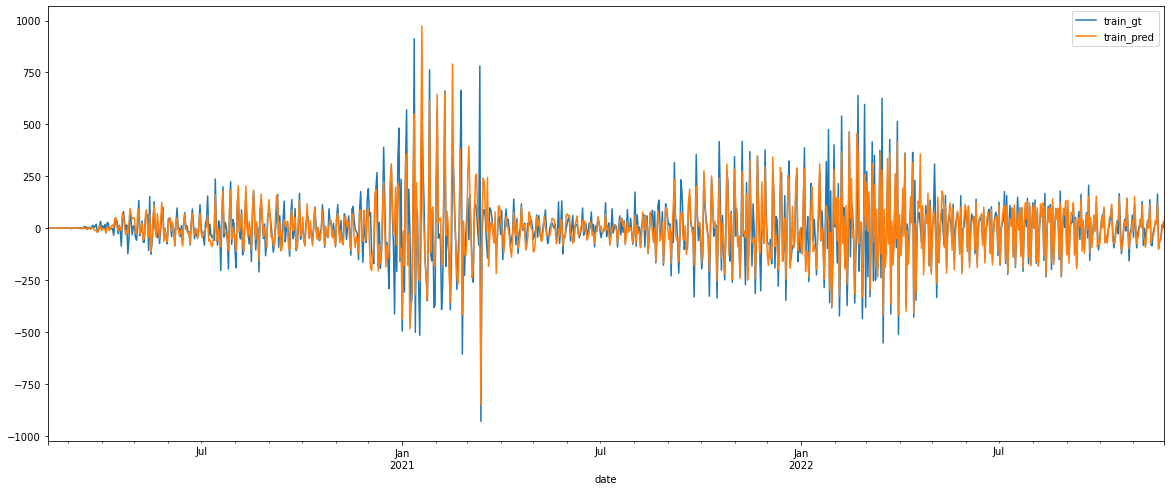

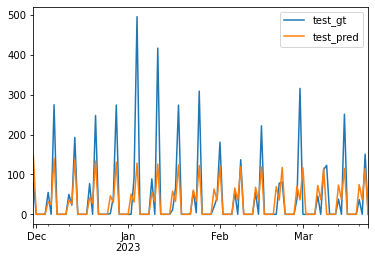

Training Set Metrics:
R-squared: 0.6906852451802148
MAE: 50.44461315868715
MASE: 0.32091887939372526

Testing Set Metrics:
R-squared: 0.48021401940022224
MAE: 29.869548992034648
MASE: 0.3732867768303379


In [962]:
train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
west_test[west_test<0] = 0
#test_pred = test_pred * 1.2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [796]:
west_auto = auto_arima(west_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(west_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14624.753, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=14132.681, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14472.144, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13939.576, Time=1.76 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=14295.175, Time=0.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13814.483, Time=1.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=14096.545, Time=1.19 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=16.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13630.779, Time=3.99 sec
 ARIMA(3,1,0)(1,1,0)[12]             : A

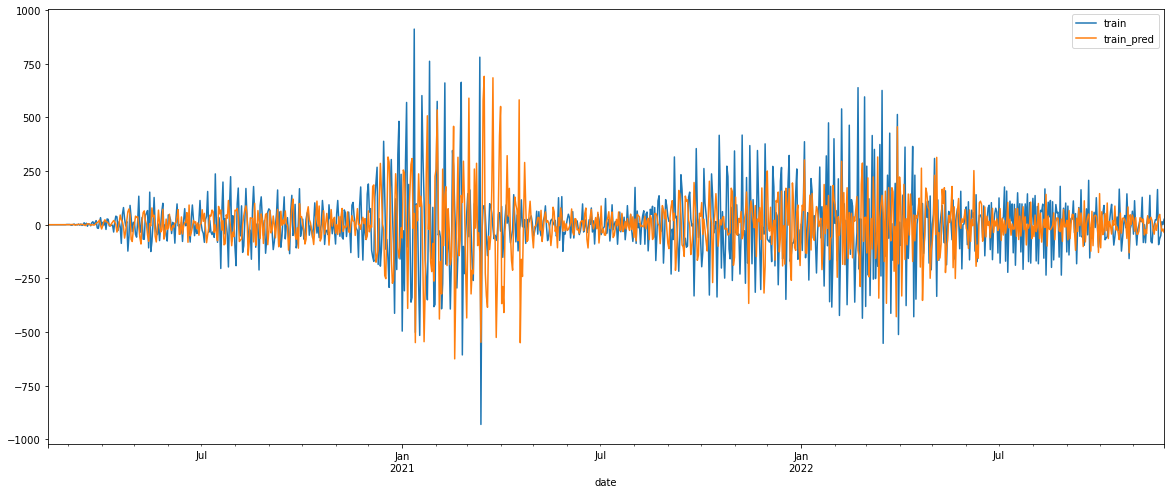

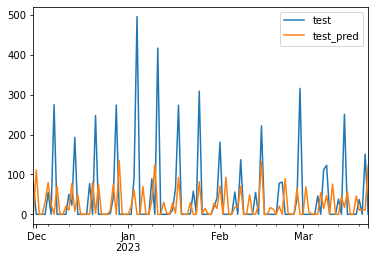

Training Set Metrics:
R-squared: -0.607636129363849
MAE: 133.0555553517825
MASE: 0.8464737272596247

Testing Set Metrics:
R-squared: -0.14927125713356015
MAE: 53.16125975397489
MASE: 0.664368762685154


In [863]:
train_pred=west_auto.fittedvalues()
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=west_auto.predict(n_periods=len(west_test))
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [803]:
n_periods=12
forecast, conf_int = west_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30     0.000000
2022-12-01    92.567667
2022-12-02     0.000000
2022-12-03     0.000000
2022-12-04    26.545014
2022-12-05    66.521916
2022-12-06    20.390438
2022-12-07     0.000000
2022-12-08    58.612100
2022-12-09     0.000000
2022-12-10     0.000000
2022-12-11    17.084641
Freq: D, dtype: float64
Confidence Interval: [[-415.38114736  370.17367259]
 [-309.67333232  494.80866548]
 [-422.04390567  385.10984075]
 [-560.64918576  314.82110405]
 [-430.26628975  483.35631821]
 [-391.021956    524.06578746]
 [-443.44456731  484.22544394]
 [-537.30517425  431.52537962]
 [-433.49278746  550.71698829]
 [-505.31552063  486.33054573]
 [-602.31948557  408.84506574]
 [-500.07830874  534.24759045]]


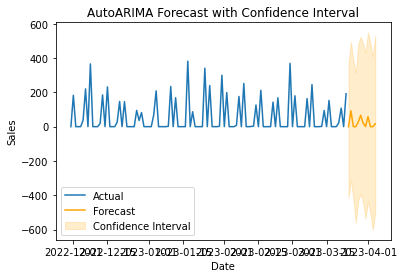

In [804]:
forecast_index = pd.date_range(west_test.index[-1], periods=n_periods + 1, freq=west_test.index.freq)[-n_periods:]

plt.plot(west_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()